# NEW CODE (start from here)

In [11]:
# Install the tsfm library
! pip install "tsfm_public[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.18"

In [1]:
import math
import os
import tempfile
import pandas as pd
import torch
import torch.nn.utils.prune as prune
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
import seaborn as sns
from collections import defaultdict
import pickle

from tsfm_public import (
    TimeSeriesPreprocessor,
    TinyTimeMixerForPrediction,
    TrackingCallback,
    count_parameters,
    get_datasets,
)
from tsfm_public.toolkit.visualization import plot_predictions

In [12]:
SEED = 42
set_seed(SEED)

target_dataset = "ettm2"
DATA_ROOT_PATH = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTm2.csv"

# Results dir
OUT_DIR = "ttm_iterative_pruning_models"
os.makedirs(OUT_DIR, exist_ok=True)

# Forecasting parameters
context_length = 512
forecast_length = 96
fewshot_fraction = 0.05

# TTM model path and revision
TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"
TTM_MODEL_REVISION = "main"

# Iterative pruning parameters
PRUNING_RATIOS = [0.0, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]  # Progressive pruning ratios
RETRAINING_EPOCHS = 3  # Epochs for retraining after each pruning step
RETRAINING_LR = 0.001  # Learning rate for retraining

# Weight Visualization Functions
def extract_model_weights(model, normalize=True):
    """Extract weights from all Linear layers in the model"""
    layer_weights = {}
    all_weights = []

    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            weights = module.weight.data.cpu().numpy().flatten()

            if normalize:
                mean = np.mean(weights)
                std = np.std(weights)
                normalized_weights = (weights - mean) / (std + 1e-8)
                layer_weights[name] = normalized_weights
                all_weights.extend(normalized_weights)
            else:
                layer_weights[name] = weights
                all_weights.extend(weights)

    return layer_weights, np.array(all_weights)

def plot_weight_distributions(layer_weights, title_prefix="", save_path=None):
    """Plot layer-wise weight distributions"""
    num_layers = len(layer_weights)
    if num_layers == 0:
        print("No layers found for plotting")
        return

    cols = min(4, num_layers)  # Max 4 columns
    rows = (num_layers + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    fig.suptitle(f'{title_prefix} Layer-wise Weight Distributions', fontsize=16, fontweight='bold')

    # Handle single row case
    if rows == 1 and cols == 1:
        axes = [axes]
    elif rows == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for i, (layer_name, weights) in enumerate(layer_weights.items()):
        ax = axes[i] if len(axes) > 1 else axes

        # Count zero weights for sparsity
        zero_count = np.sum(np.abs(weights) < 1e-8)
        total_count = len(weights)
        sparsity = zero_count / total_count

        # Plot histogram
        sns.histplot(weights, bins=50, kde=True, color='steelblue', ax=ax, alpha=0.7)

        # Add vertical line at zero
        ax.axvline(x=0, color='red', linestyle='--', alpha=0.8, linewidth=2)

        # Clean up layer name for display
        clean_name = layer_name.replace('backbone.', '').replace('mixer_layers.', 'L')
        ax.set_title(f"{clean_name}\nSparsity: {sparsity:.1%} ({zero_count}/{total_count})", fontsize=10)
        ax.set_xlabel("Weight Value", fontsize=9)
        ax.set_ylabel("Frequency", fontsize=9)
        ax.grid(True, alpha=0.3)

    # Hide empty subplots
    for i in range(num_layers, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def comprehensive_weight_analysis(model, title_prefix="", save_dir=None):
    """Run comprehensive weight analysis for a single model"""
    print(f"\n=== {title_prefix} Weight Analysis ===")

    # Extract weights
    layer_weights, all_weights = extract_model_weights(model, normalize=True)
    layer_weights_raw, all_weights_raw = extract_model_weights(model, normalize=False)

    save_path_1 = f"{save_dir}/{title_prefix.lower().replace(' ', '_')}_layer_distributions.png" if save_dir else None

    # Plot layer-wise distributions (normalized)
    plot_weight_distributions(layer_weights, title_prefix + " (Normalized)", save_path_1)

    # Print summary statistics
    zero_count = np.sum(np.abs(all_weights_raw) < 1e-8)
    total_count = len(all_weights_raw)
    sparsity = zero_count / total_count

    print(f"{title_prefix} Summary:")
    print(f"  Total parameters: {total_count:,}")
    print(f"  Zero parameters: {zero_count:,}")
    print(f"  Non-zero parameters: {total_count - zero_count:,}")
    print(f"  Sparsity: {sparsity:.4f} ({sparsity:.2%})")
    print(f"  Weight range: [{np.min(all_weights_raw):.6f}, {np.max(all_weights_raw):.6f}]")
    print(f"  Mean absolute weight: {np.mean(np.abs(all_weights_raw)):.6f}")

# ========== Data Preparation ==========
print("Loading and preparing data...")

# Load the data with proper datetime parsing
try:
    data = pd.read_csv(DATA_ROOT_PATH)
    # Convert date column to datetime if it exists
    if 'date' in data.columns:
        data['date'] = pd.to_datetime(data['date'])
    elif data.columns[0] in ['date', 'timestamp', 'time']:
        data[data.columns[0]] = pd.to_datetime(data[data.columns[0]])
        data = data.rename(columns={data.columns[0]: 'date'})
    else:
        # If no date column, create one
        data['date'] = pd.date_range(start='2016-07-01', periods=len(data), freq='15min')

    print("✓ Data loaded successfully")
    print(f"Date range: {data['date'].min()} to {data['date'].max()}")

except Exception as e:
    print(f"Error loading data: {e}")
    print("Creating synthetic dataset...")

    # Create synthetic data
    dates = pd.date_range(start='2016-07-01', end='2018-06-26', freq='15min')
    np.random.seed(42)

    synthetic_data = {
        'date': dates,
        'HUFL': np.random.randn(len(dates)) * 5 + 40,
        'HULL': np.random.randn(len(dates)) * 3 + 10,
        'MUFL': np.random.randn(len(dates)) * 8 + 35,
        'MULL': np.random.randn(len(dates)) * 4 + 8,
        'LUFL': np.random.randn(len(dates)) * 6 + 4,
        'LULL': np.random.randn(len(dates)) * 2 + 1,
        'OT': np.random.randn(len(dates)) * 4 + 40
    }

    data = pd.DataFrame(synthetic_data)

# Define the data structure
timestamp_column = "date"
id_columns = []
target_columns = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL", "OT"]

# Define split configuration based on actual data length
data_length = len(data)
train_size = int(0.7 * data_length)
valid_size = int(0.15 * data_length)

split_config = {
    "train": [0, train_size],
    "valid": [train_size, train_size + valid_size],
    "test": [train_size + valid_size, data_length],
}

print(f"Data length: {data_length}")
print(f"Split config: {split_config}")

# Set up column specifiers
column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [],
}

# Create TimeSeriesPreprocessor
tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,
    prediction_length=forecast_length,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

# Get datasets - Use full training dataset for retraining
train_dataset, valid_dataset, test_dataset = get_datasets(
    tsp, data, split_config, fewshot_fraction=1.0, fewshot_location="first"  # Use full dataset
)

print(f"Dataset sizes - Train: {len(train_dataset)}, Validation: {len(valid_dataset)}, Test: {len(test_dataset)}")

Loading and preparing data...
✓ Data loaded successfully
Date range: 2016-07-01 00:00:00 to 2018-06-26 19:45:00
Data length: 69680
Split config: {'train': [0, 48776], 'valid': [48776, 59228], 'test': [59228, 69680]}
Dataset sizes - Train: 48169, Validation: 10357, Test: 10357


In [16]:
# ========== Helper Functions ==========
def run_inference_and_calculate_metrics(model, test_dataset, device='cpu', max_samples=50):
    """Run inference and calculate metrics"""
    model.eval()
    model.to(device)

    total_mse = 0.0
    total_mae = 0.0
    num_samples = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for i, batch in enumerate(test_dataset):
            if i >= max_samples:  # Limit for demo purposes
                break

            # Prepare input
            past_values = batch['past_values'].unsqueeze(0).to(device)
            future_values = batch['future_values'].unsqueeze(0).to(device)

            # Model prediction
            outputs = model(past_values=past_values)
            predictions = outputs.prediction_outputs

            # Calculate metrics
            mse = torch.mean((predictions - future_values) ** 2).item()
            mae = torch.mean(torch.abs(predictions - future_values)).item()

            total_mse += mse
            total_mae += mae
            num_samples += 1

            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(future_values.cpu().numpy())

    avg_mse = total_mse / num_samples
    avg_mae = total_mae / num_samples

    return avg_mse, avg_mae, np.concatenate(all_predictions), np.concatenate(all_targets)

def count_model_parameters_detailed(model):
    """
    Correctly counts total and zero parameters in a model,
    properly handling pruned layers.
    """
    total_params = 0
    zero_params = 0

    # Iterate over all modules in the model
    for module in model.modules():
        # We only want to count parameters in leaf modules (like Linear, Conv2d, etc.)
        # This check prevents double-counting parameters of nested modules.
        if len(list(module.children())) > 0:
            continue

        # Check for both 'weight' and 'bias' parameters
        for param_name in ['weight', 'bias']:
            if hasattr(module, param_name):
                param = getattr(module, param_name)
                if param is not None and isinstance(param, torch.Tensor):
                    # For a pruned layer, module.weight returns the masked tensor.
                    # For a non-pruned layer, it's just the normal parameter.
                    # This works correctly for both cases.
                    total_params += param.numel()
                    zero_params += torch.sum(param.data == 0).item()

    if total_params == 0:
        return 0, 0, 0, 0

    sparsity = zero_params / total_params
    non_zero_params = total_params - zero_params

    return total_params, non_zero_params, zero_params, sparsity

    # """Count parameters with detailed breakdown"""
    # total_params = 0
    # non_zero_params = 0
    # zero_params = 0

    # for name, param in model.named_parameters():
    #     param_count = param.numel()
    #     zero_count = (param == 0).sum().item()
    #     non_zero_count = param_count - zero_count

    #     total_params += param_count
    #     non_zero_params += non_zero_count
    #     zero_params += zero_count

    # sparsity = zero_params / total_params if total_params > 0 else 0

    # return total_params, non_zero_params, zero_params, sparsity


def apply_magnitude_pruning(model, pruning_ratio):
    """Apply magnitude-based pruning to the model"""
    parameters_to_prune = []

    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            parameters_to_prune.append((module, 'weight'))

    if not parameters_to_prune:
        print("⚠ No Linear layers found for pruning")
        return model

    # Apply global magnitude-based pruning
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=pruning_ratio,
    )

    # # Make pruning permanent
    # with torch.no_grad():
    #     for module, param_name in parameters_to_prune:
    #         try:
    #             prune.remove(module, param_name)
    #         except Exception as e:
    #             print(f"⚠ Could not remove pruning from {param_name}: {e}")

    # Keep pruning masks active (do NOT remove them)
    print(f"✓ Pruning applied with masks maintained")

    return model

def retrain_model(model, train_dataset, valid_dataset, epochs=3, learning_rate=0.001):
    """Retrain the pruned model"""
    print(f"Retraining model for {epochs} epochs with LR={learning_rate}")

    # Store original forward method to maintain masks during training
    def masked_forward_hook(module, input, output):
        # Ensure masks are applied after each forward pass
        for name, param in module.named_parameters():
            if hasattr(module, f'{name}_mask'):
                mask = getattr(module, f'{name}_mask')
                param.data = param.data * mask

    # Register hooks to maintain sparsity during training
    hooks = []
    for name, module in model.named_modules():
        if hasattr(module, 'weight_mask'):  # Check if module has pruning mask
            hook = module.register_forward_hook(masked_forward_hook)
            hooks.append(hook)

    # Training arguments
    training_args = TrainingArguments(
        output_dir=os.path.join(OUT_DIR, "temp_retraining"),
        overwrite_output_dir=True,
        learning_rate=learning_rate,
        num_train_epochs=epochs,
        do_eval=True,
        eval_strategy="epoch",
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        gradient_accumulation_steps=1,
        dataloader_num_workers=0,
        report_to=None,
        save_strategy="epoch",  # Don't save during training
        logging_strategy="epoch",
        logging_dir=None,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        seed=SEED,
        dataloader_pin_memory=False,
        remove_unused_columns=True,
        dataloader_drop_last=False,
        warmup_ratio=0.1,
        weight_decay=0.01,
    )

    # Early stopping callback
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=2,
        early_stopping_threshold=0.001,
    )

    # Create trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,
        callbacks=[early_stopping_callback],
    )

    # Train the model
    try:
        train_result = trainer.train()
        print(f"✓ Retraining completed successfully")

        # Remove hooks
        for hook in hooks:
            hook.remove()

        return trainer.model, True
    except Exception as e:
        print(f"⚠ Retraining failed: {e}")
        # Remove hooks
        for hook in hooks:
            hook.remove()
        return model, False

def save_model_checkpoint(model, path, metadata=None):
    """Save model checkpoint with metadata"""
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'metadata': metadata or {}
    }
    torch.save(checkpoint, path)
    print(f"✓ Model saved to {path}")

Loading pre-trained TTM model...
✓ Model loaded successfully

=== Baseline Model Evaluation ===
Baseline MSE: 0.116015
Baseline MAE: 0.233781
Baseline Parameters: 805,280 (sparsity: 0.0000)
✓ Model saved to ttm_iterative_pruning_models/baseline_model.pth

=== Baseline Model Weight Analysis ===


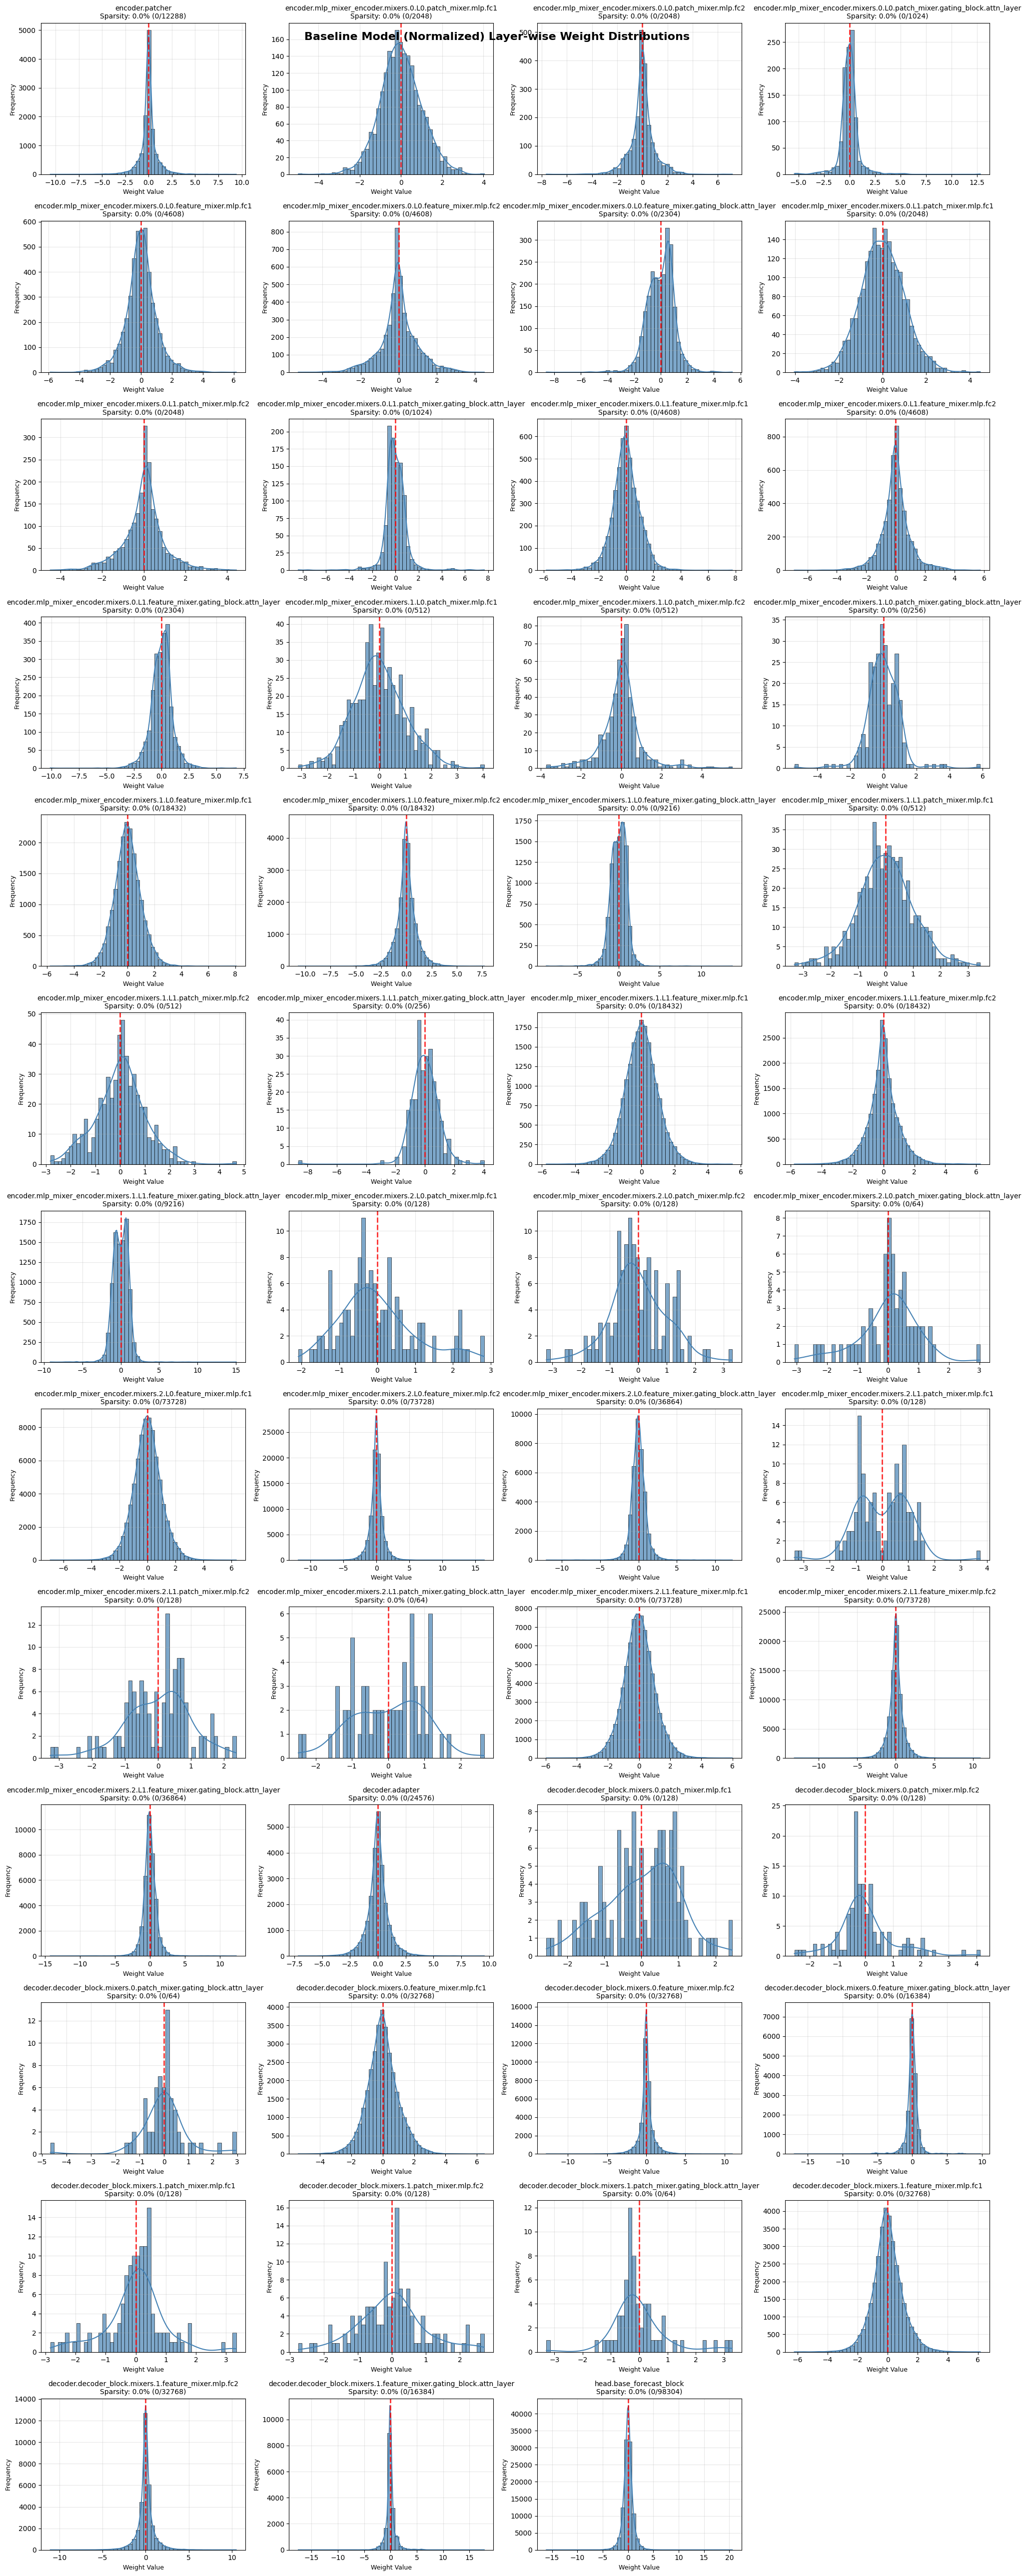

Baseline Model Summary:
  Total parameters: 796,928
  Zero parameters: 0
  Non-zero parameters: 796,928
  Sparsity: 0.0000 (0.00%)
  Weight range: [-3.916744, 3.378180]
  Mean absolute weight: 0.092815


In [17]:
# ========== Load Pre-trained TTM Model ==========
print("Loading pre-trained TTM model...")
baseline_model = TinyTimeMixerForPrediction.from_pretrained(TTM_MODEL_PATH, revision=TTM_MODEL_REVISION)
print(f"✓ Model loaded successfully")

# ========== Baseline Evaluation ==========
print("\n=== Baseline Model Evaluation ===")
baseline_mse, baseline_mae, baseline_preds, baseline_targets = run_inference_and_calculate_metrics(baseline_model, test_dataset)
baseline_total_params, baseline_non_zero_params, baseline_zero_params, baseline_sparsity = count_model_parameters_detailed(baseline_model)

print(f"Baseline MSE: {baseline_mse:.6f}")
print(f"Baseline MAE: {baseline_mae:.6f}")
print(f"Baseline Parameters: {baseline_total_params:,} (sparsity: {baseline_sparsity:.4f})")

# Save baseline model
save_model_checkpoint(baseline_model, f"{OUT_DIR}/baseline_model.pth",
                     {'mse': baseline_mse, 'mae': baseline_mae, 'sparsity': baseline_sparsity})

# Baseline weight analysis
comprehensive_weight_analysis(baseline_model, "Baseline Model", OUT_DIR)


ITERATIVE PRUNING AND RETRAINING

--- Processing Pruning Ratio: 0.0% ---
✓ Model saved to ttm_iterative_pruning_models/pruned_model_0.0.pth

--- Processing Pruning Ratio: 20.0% ---
Applying 20.0% pruning...
✓ Pruning applied with masks maintained
Pruned-only MSE: 0.173013, Sparsity: 0.1979
Retraining model for 3 epochs with LR=0.001


✓ Retraining completed successfully
Retrained MSE: 0.115487, Sparsity: 0.1979
✓ Model saved to ttm_iterative_pruning_models/pruned_model_0.2.pth
✓ Model saved to ttm_iterative_pruning_models/retrained_model_0.2.pth

=== Pruned 20.0% Weight Analysis ===


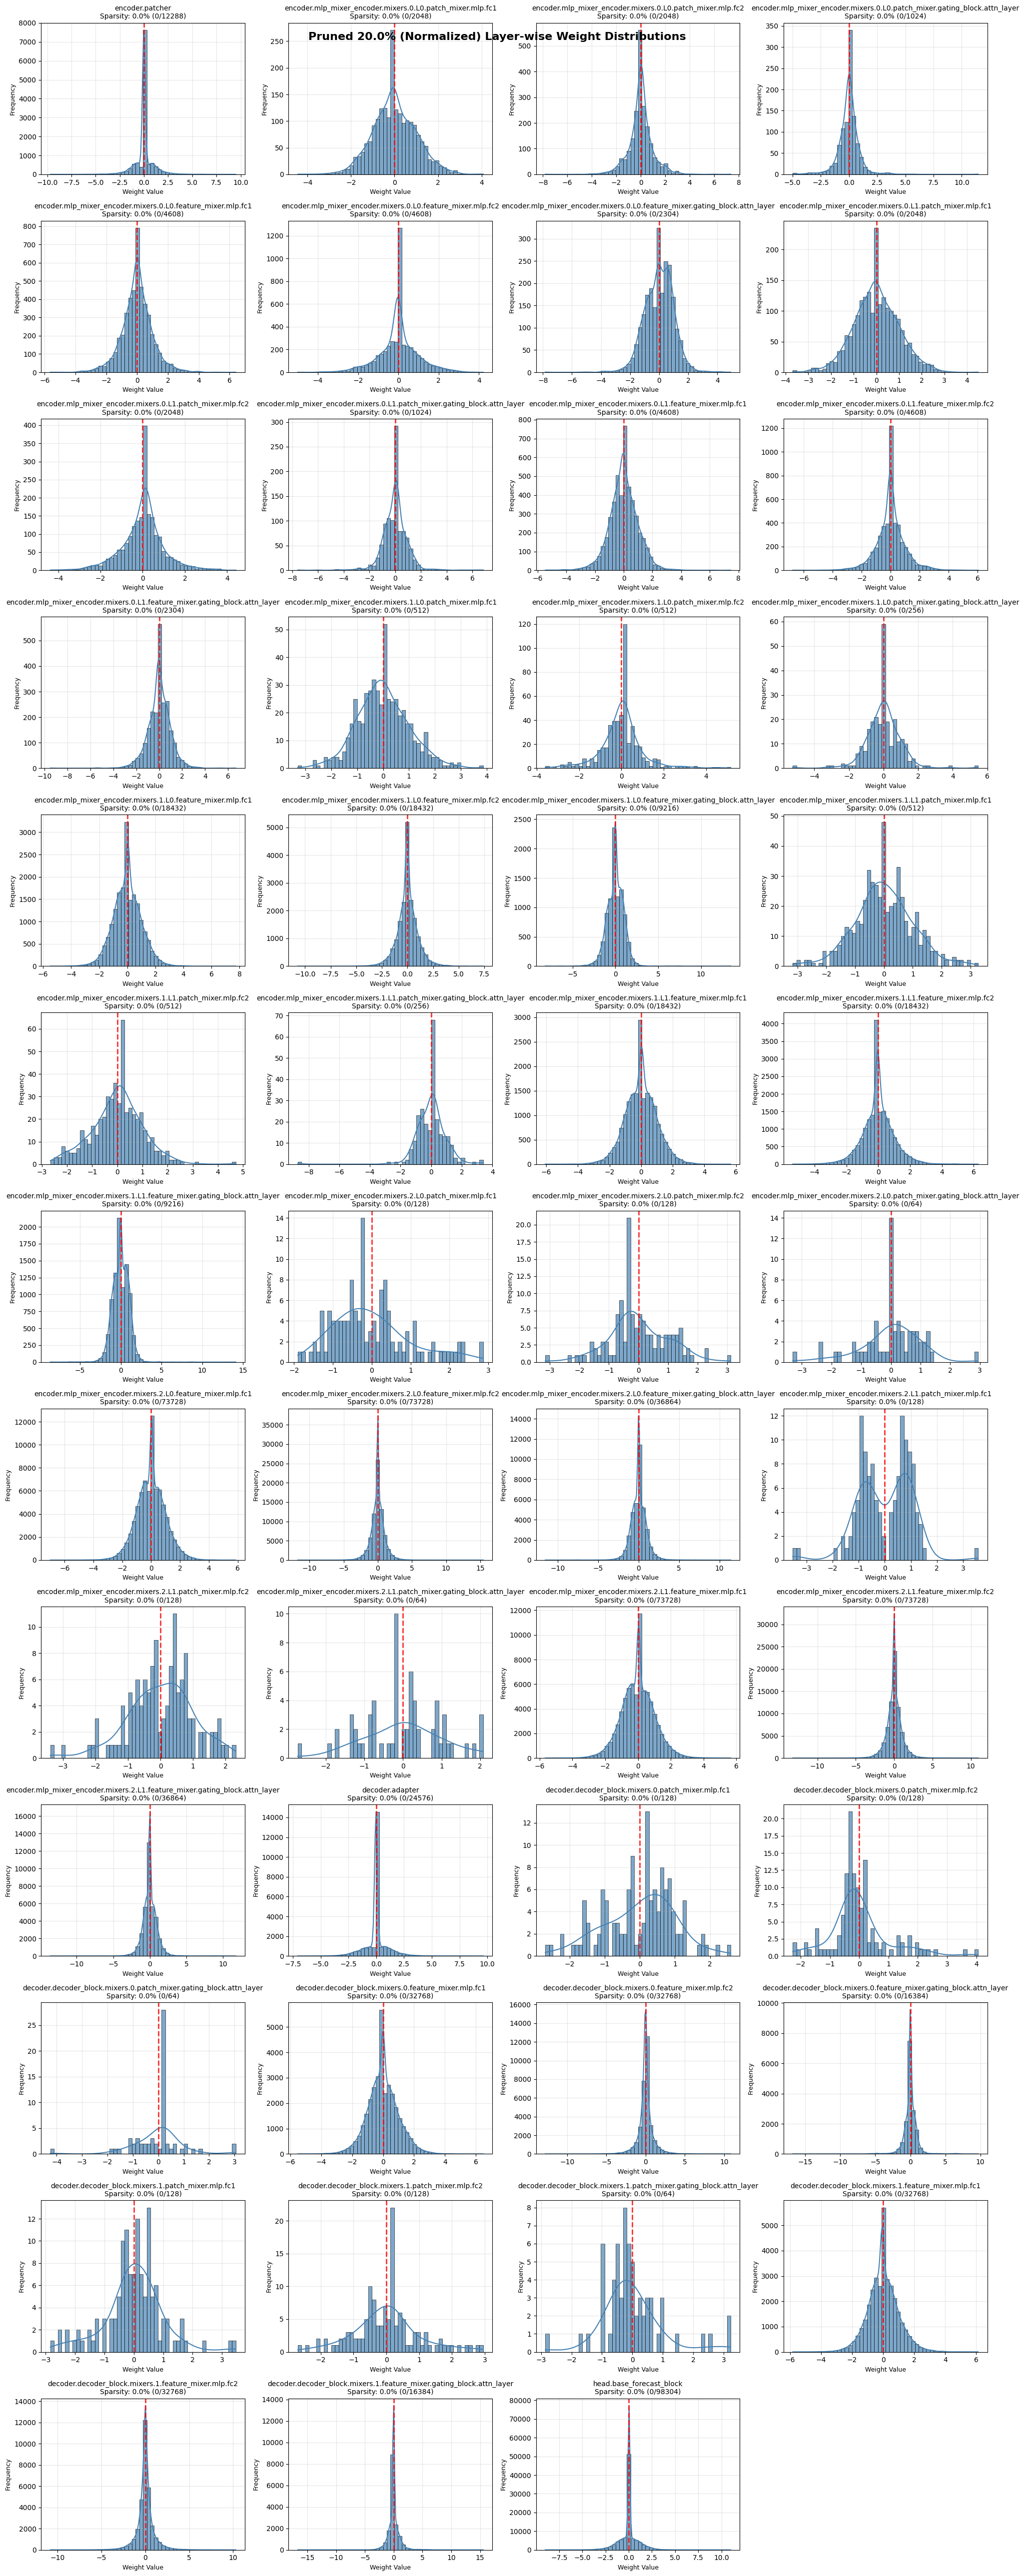

Pruned 20.0% Summary:
  Total parameters: 796,928
  Zero parameters: 159,386
  Non-zero parameters: 637,542
  Sparsity: 0.2000 (20.00%)
  Weight range: [-3.814899, 3.240437]
  Mean absolute weight: 0.090052

=== Retrained 20.0% Weight Analysis ===


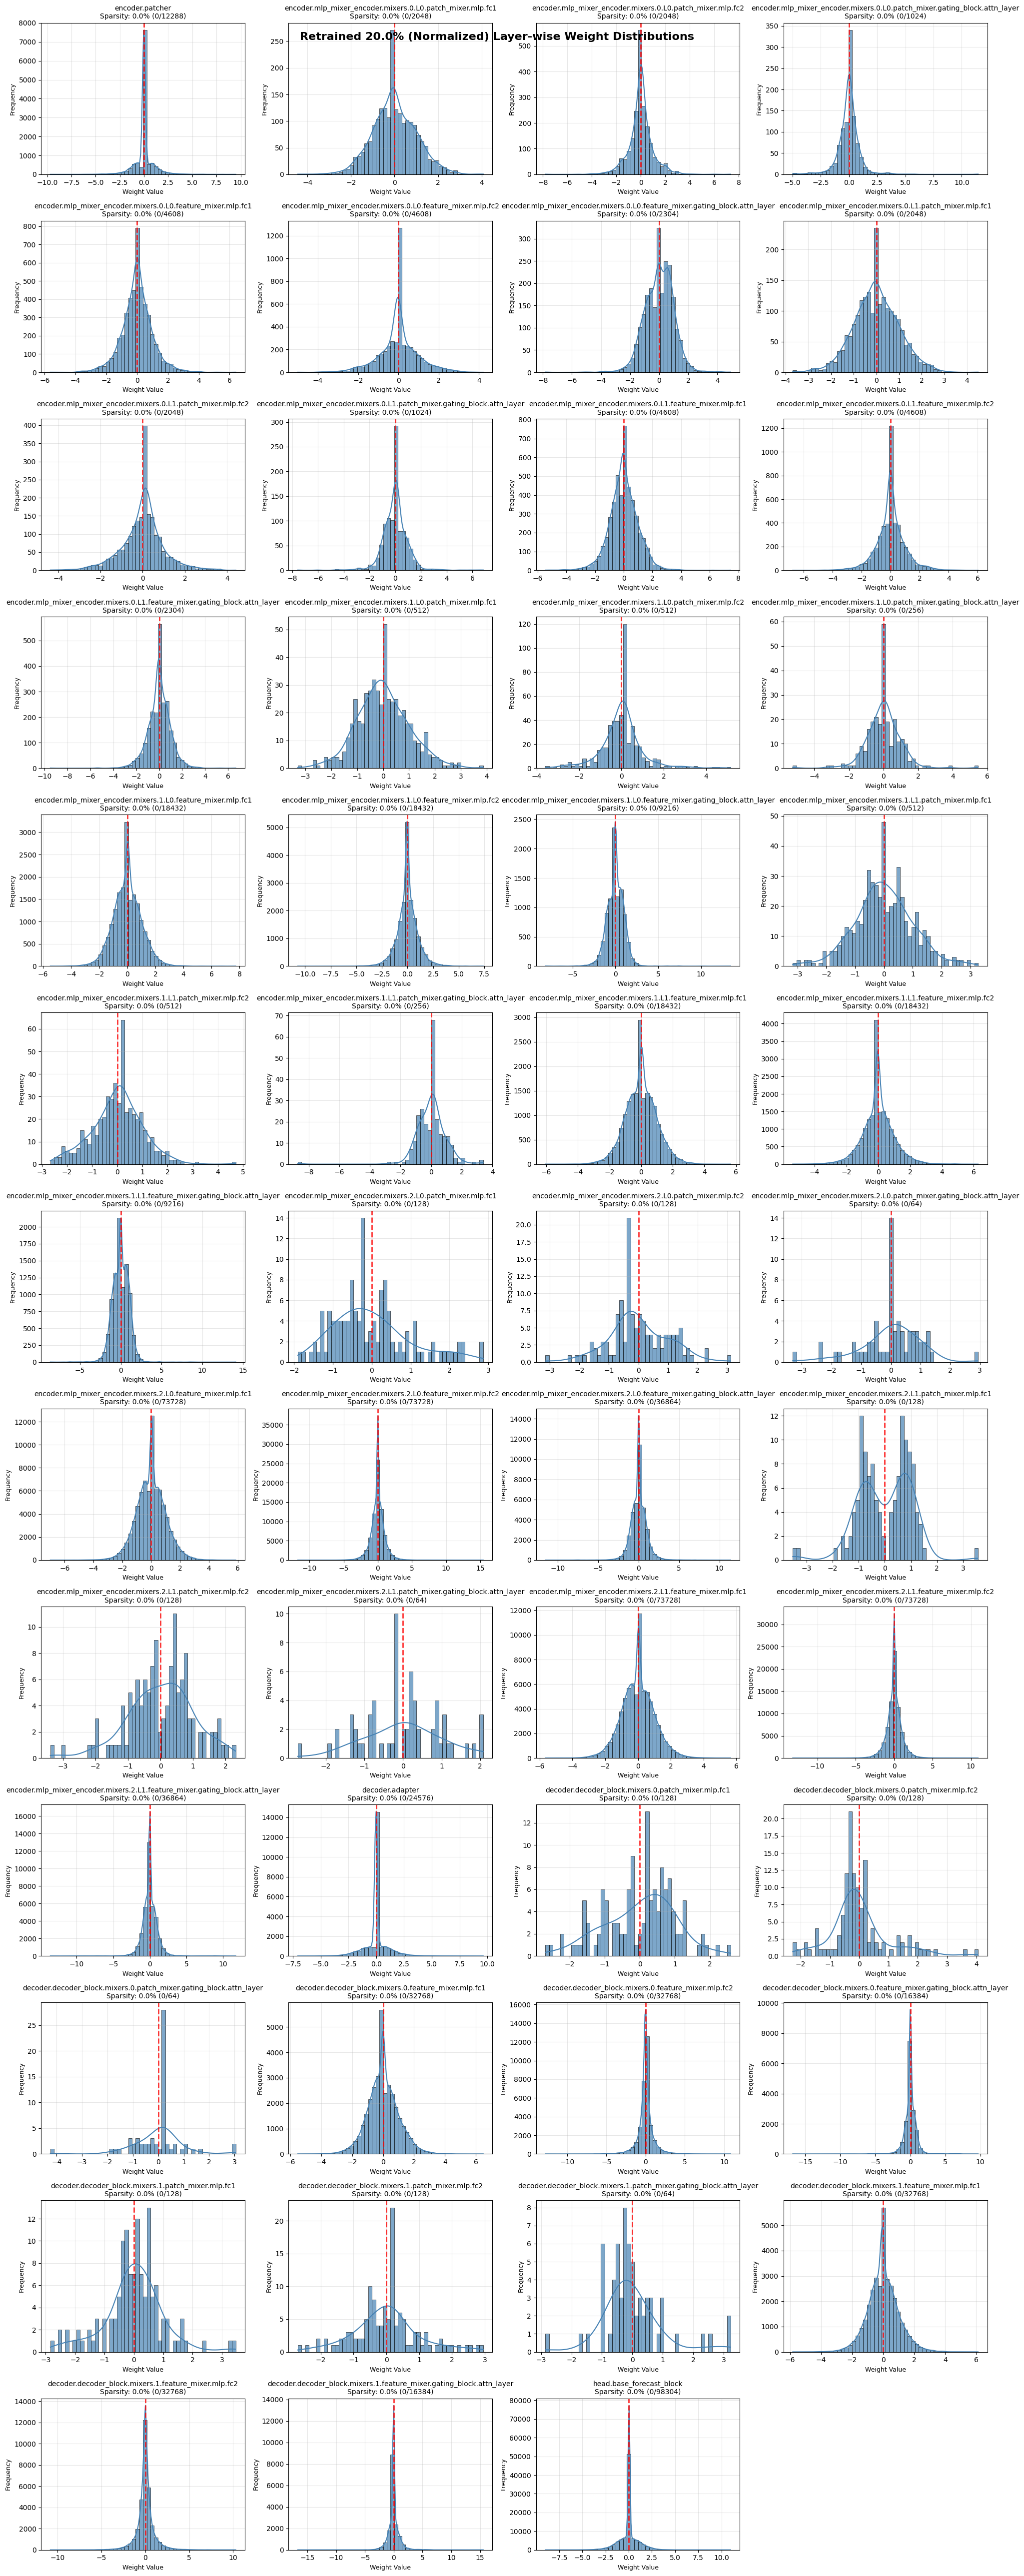

Retrained 20.0% Summary:
  Total parameters: 796,928
  Zero parameters: 159,386
  Non-zero parameters: 637,542
  Sparsity: 0.2000 (20.00%)
  Weight range: [-3.814899, 3.240437]
  Mean absolute weight: 0.090052

--- Processing Pruning Ratio: 40.0% ---
Applying 40.0% pruning...
✓ Pruning applied with masks maintained
Pruned-only MSE: 0.170170, Sparsity: 0.3959
Retraining model for 3 epochs with LR=0.001


✓ Retraining completed successfully
Retrained MSE: 0.108534, Sparsity: 0.3959
✓ Model saved to ttm_iterative_pruning_models/pruned_model_0.4.pth
✓ Model saved to ttm_iterative_pruning_models/retrained_model_0.4.pth

--- Processing Pruning Ratio: 50.0% ---
Applying 50.0% pruning...
✓ Pruning applied with masks maintained
Pruned-only MSE: 0.169248, Sparsity: 0.4948
Retraining model for 3 epochs with LR=0.001


✓ Retraining completed successfully
Retrained MSE: 0.111875, Sparsity: 0.4948
✓ Model saved to ttm_iterative_pruning_models/pruned_model_0.5.pth
✓ Model saved to ttm_iterative_pruning_models/retrained_model_0.5.pth

=== Pruned 50.0% Weight Analysis ===


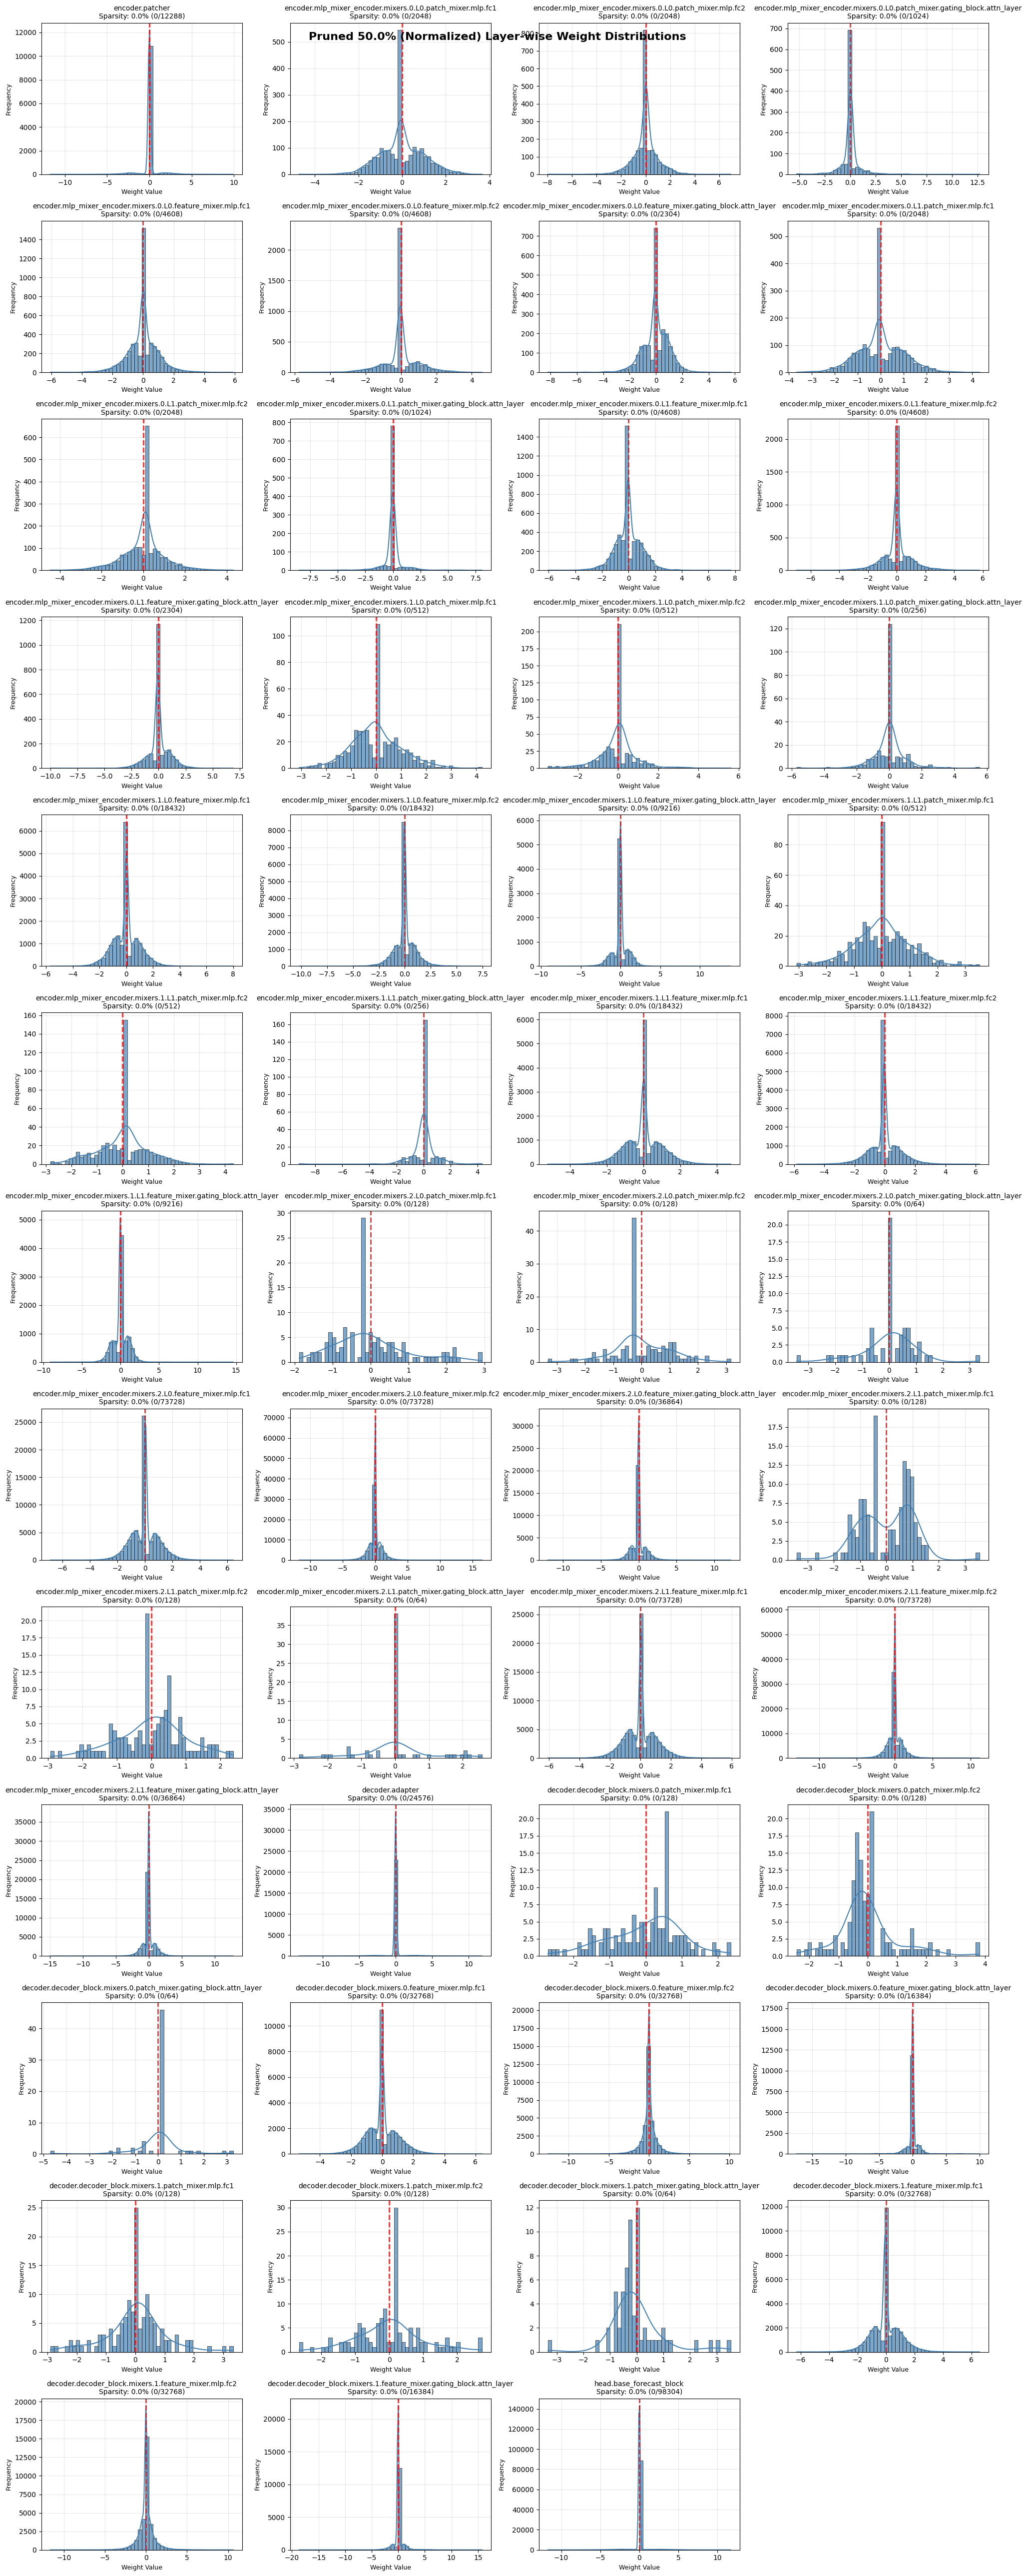

Pruned 50.0% Summary:
  Total parameters: 796,928
  Zero parameters: 398,464
  Non-zero parameters: 398,464
  Sparsity: 0.5000 (50.00%)
  Weight range: [-3.748690, 3.037173]
  Mean absolute weight: 0.079511

=== Retrained 50.0% Weight Analysis ===


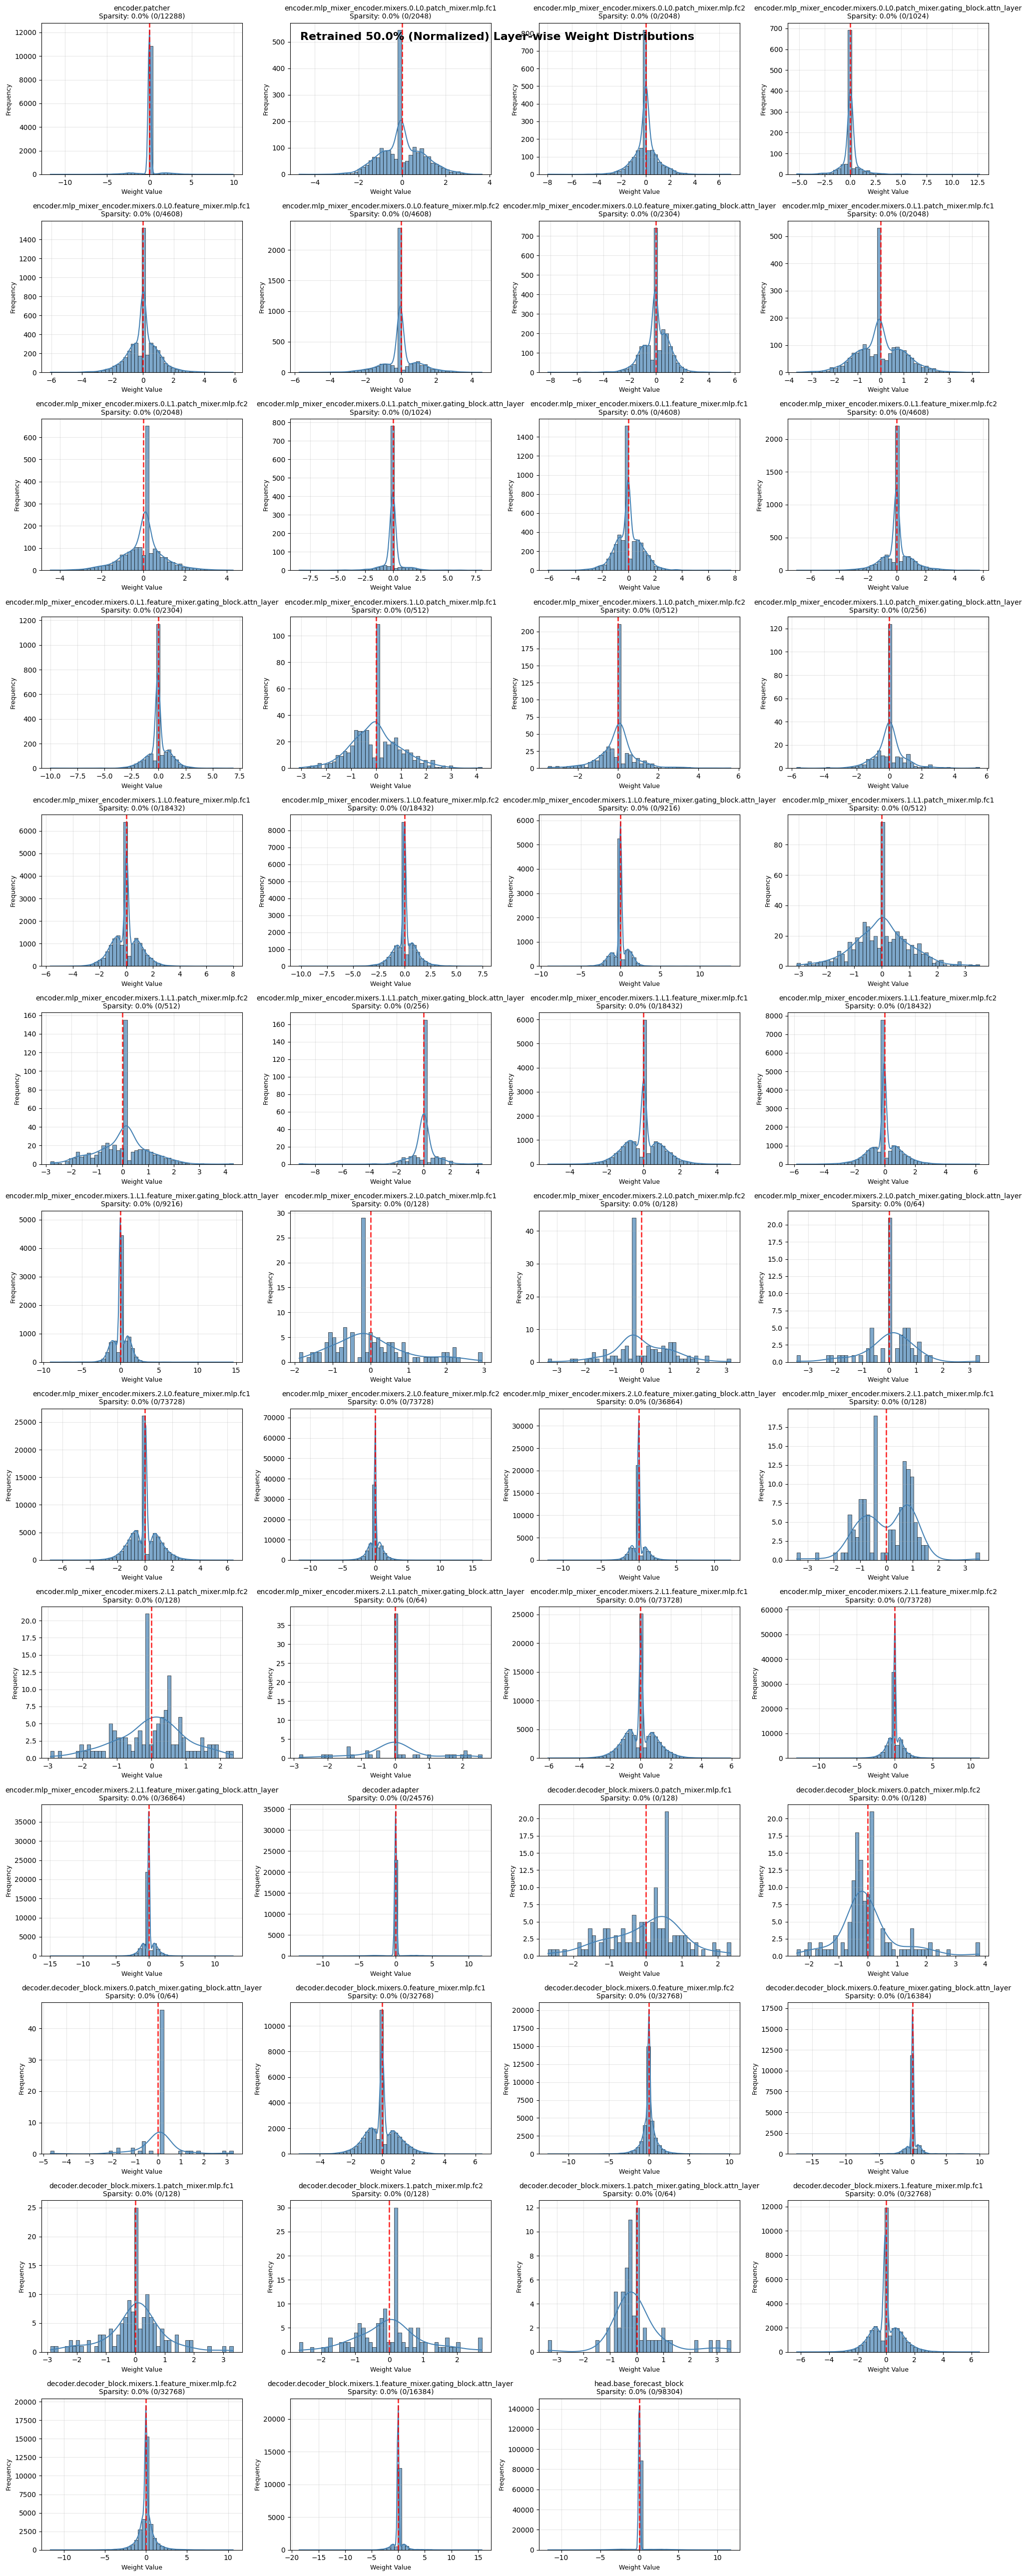

Retrained 50.0% Summary:
  Total parameters: 796,928
  Zero parameters: 398,464
  Non-zero parameters: 398,464
  Sparsity: 0.5000 (50.00%)
  Weight range: [-3.748690, 3.037173]
  Mean absolute weight: 0.079511

--- Processing Pruning Ratio: 60.0% ---
Applying 60.0% pruning...
✓ Pruning applied with masks maintained
Pruned-only MSE: 0.169546, Sparsity: 0.5938
Retraining model for 3 epochs with LR=0.001


✓ Retraining completed successfully
Retrained MSE: 0.113079, Sparsity: 0.5938
✓ Model saved to ttm_iterative_pruning_models/pruned_model_0.6.pth
✓ Model saved to ttm_iterative_pruning_models/retrained_model_0.6.pth

--- Processing Pruning Ratio: 70.0% ---
Applying 70.0% pruning...
✓ Pruning applied with masks maintained
Pruned-only MSE: 0.169926, Sparsity: 0.6927
Retraining model for 3 epochs with LR=0.001


✓ Retraining completed successfully
Retrained MSE: 0.118901, Sparsity: 0.6927
✓ Model saved to ttm_iterative_pruning_models/pruned_model_0.7.pth
✓ Model saved to ttm_iterative_pruning_models/retrained_model_0.7.pth

--- Processing Pruning Ratio: 80.0% ---
Applying 80.0% pruning...
✓ Pruning applied with masks maintained
Pruned-only MSE: 0.169456, Sparsity: 0.7917
Retraining model for 3 epochs with LR=0.001


✓ Retraining completed successfully
Retrained MSE: 0.147932, Sparsity: 0.7917
✓ Model saved to ttm_iterative_pruning_models/pruned_model_0.8.pth
✓ Model saved to ttm_iterative_pruning_models/retrained_model_0.8.pth

--- Processing Pruning Ratio: 90.0% ---
Applying 90.0% pruning...
✓ Pruning applied with masks maintained
Pruned-only MSE: 0.170206, Sparsity: 0.8907
Retraining model for 3 epochs with LR=0.001


✓ Retraining completed successfully
Retrained MSE: 0.169789, Sparsity: 0.8907
✓ Model saved to ttm_iterative_pruning_models/pruned_model_0.9.pth
✓ Model saved to ttm_iterative_pruning_models/retrained_model_0.9.pth

=== Pruned 90.0% Weight Analysis ===


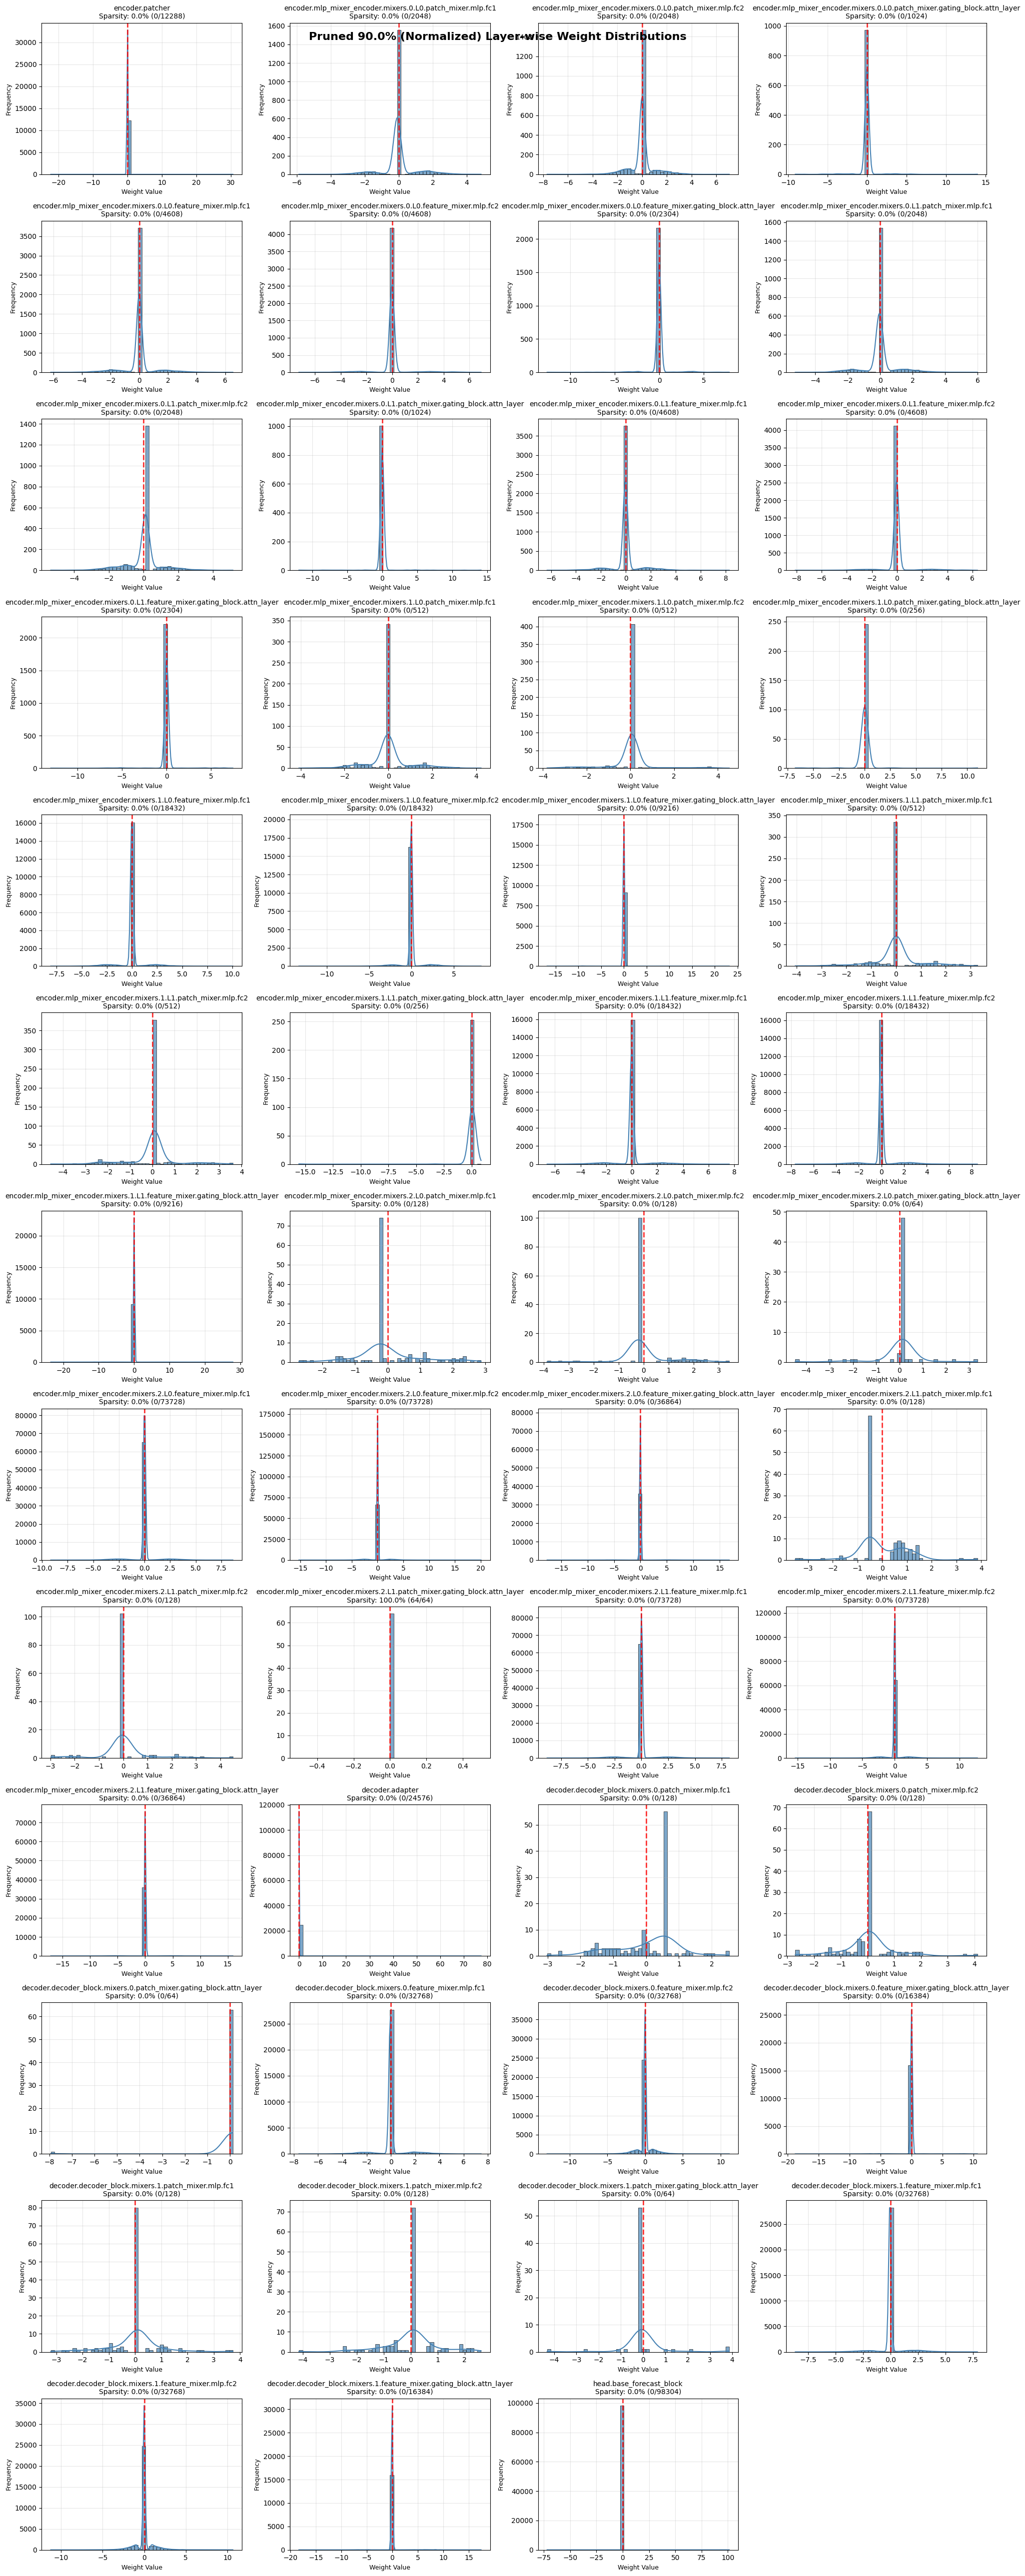

Pruned 90.0% Summary:
  Total parameters: 796,928
  Zero parameters: 717,235
  Non-zero parameters: 79,693
  Sparsity: 0.9000 (90.00%)
  Weight range: [-3.839978, 3.299654]
  Mean absolute weight: 0.034378

=== Retrained 90.0% Weight Analysis ===


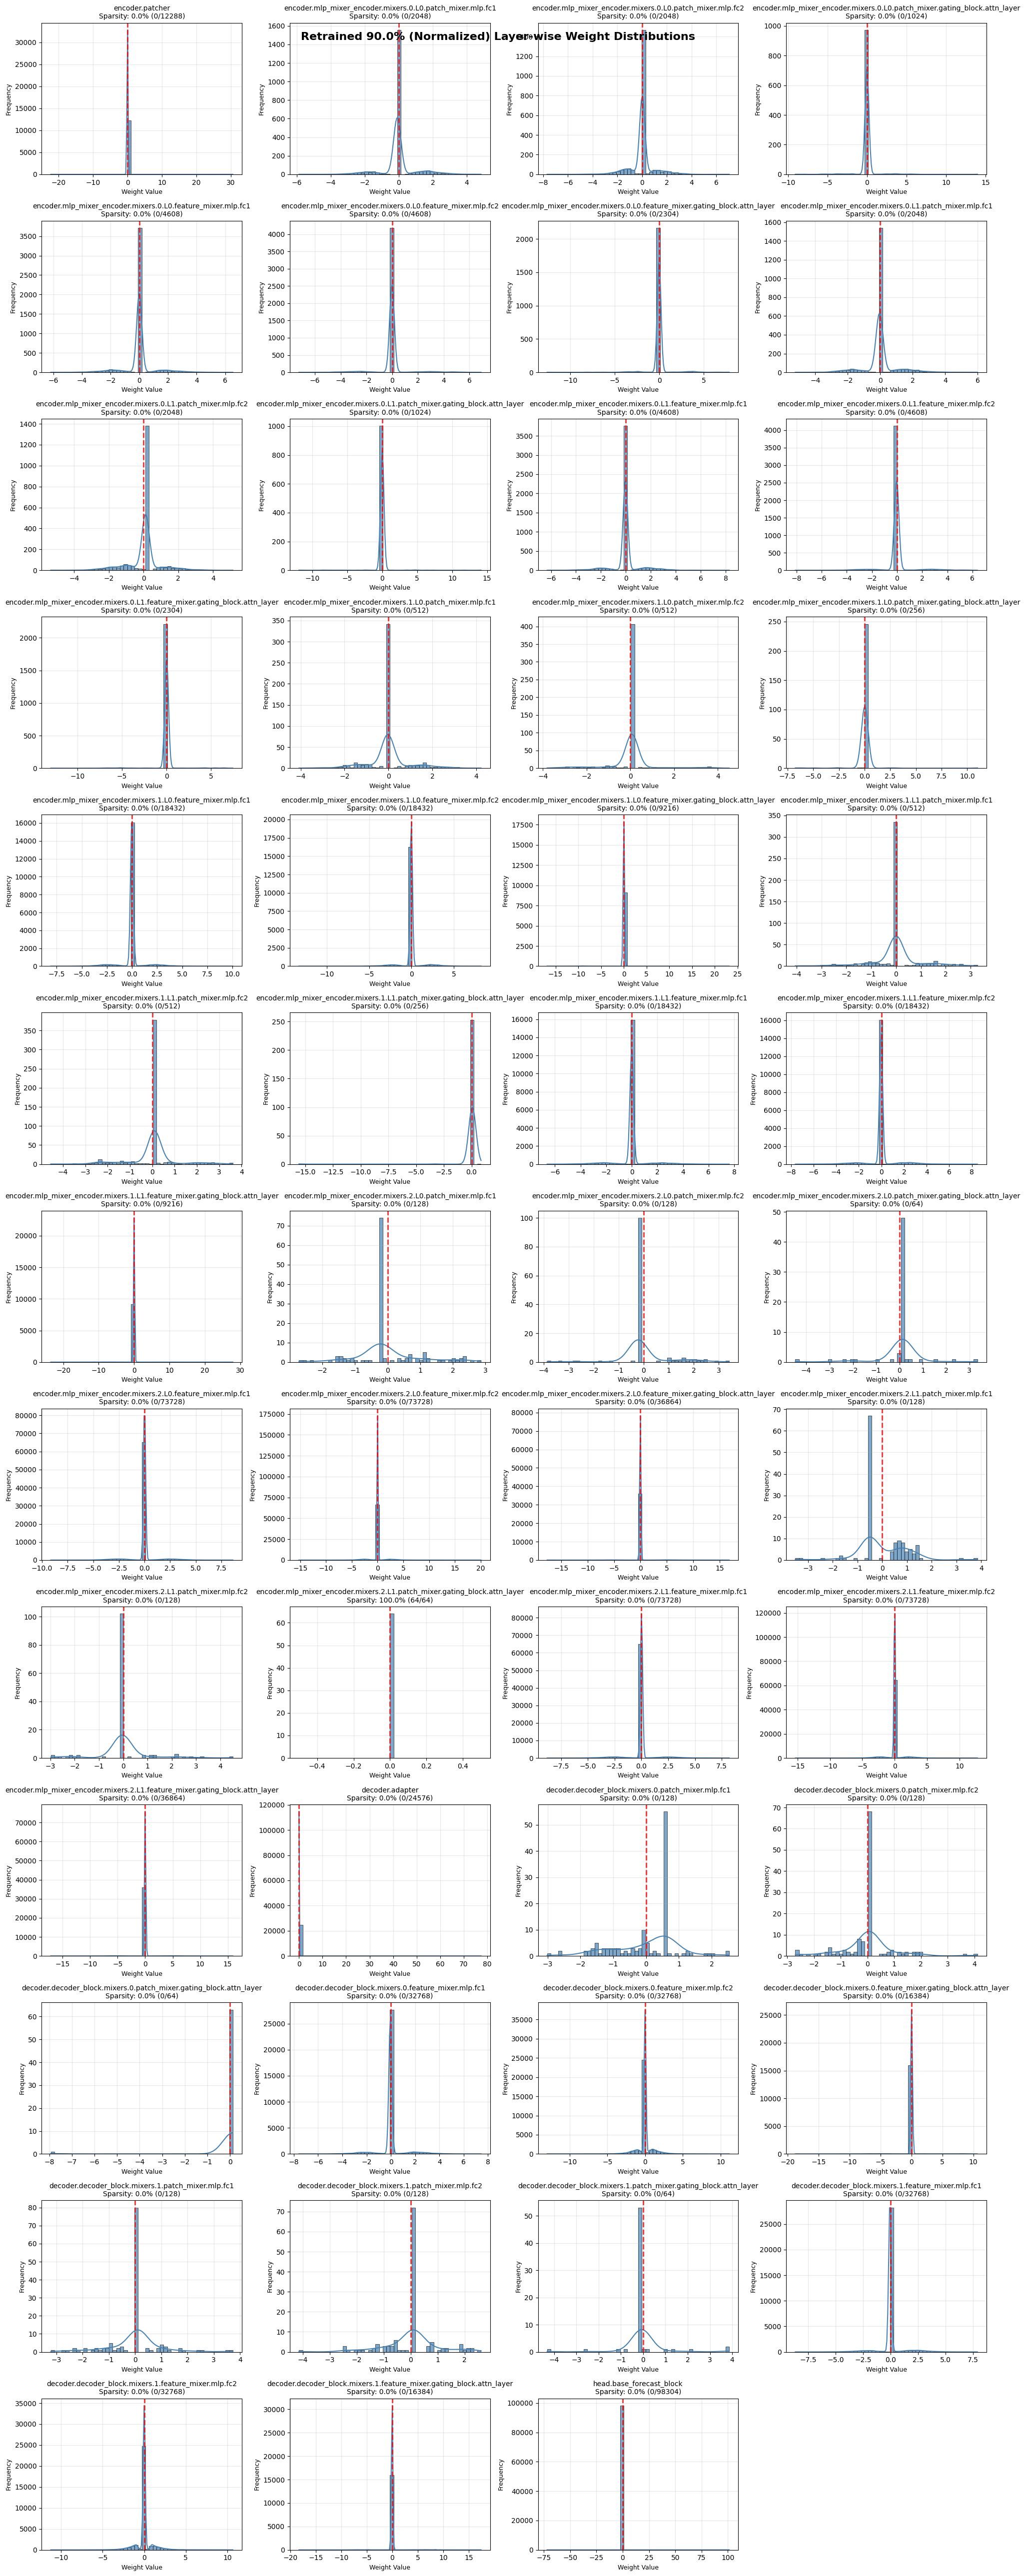

Retrained 90.0% Summary:
  Total parameters: 796,928
  Zero parameters: 717,235
  Non-zero parameters: 79,693
  Sparsity: 0.9000 (90.00%)
  Weight range: [-3.839978, 3.299654]
  Mean absolute weight: 0.034378


In [18]:
# ========== Iterative Pruning and Retraining ==========
print("\n" + "="*70)
print("ITERATIVE PRUNING AND RETRAINING")
print("="*70)

# Storage for results
results = {
    'pruning_ratios': [],
    'pruned_only_mse': [],
    'pruned_only_mae': [],
    'pruned_only_sparsity': [],
    'pruned_retrained_mse': [],
    'pruned_retrained_mae': [],
    'pruned_retrained_sparsity': []
}

# Models storage
pruned_models = {}
retrained_models = {}

for target_pruning_ratio in PRUNING_RATIOS:
    print(f"\n--- Processing Pruning Ratio: {target_pruning_ratio:.1%} ---")

    # Load fresh model for each iteration
    current_model = TinyTimeMixerForPrediction.from_pretrained(TTM_MODEL_PATH, revision=TTM_MODEL_REVISION)

    if target_pruning_ratio == 0.0:
        # Baseline case - no pruning
        pruned_model = current_model
        retrained_model = current_model

        # Evaluate
        pruned_mse, pruned_mae, _, _ = run_inference_and_calculate_metrics(pruned_model, test_dataset)
        _, _, _, pruned_sparsity = count_model_parameters_detailed(pruned_model)

        retrained_mse, retrained_mae = pruned_mse, pruned_mae
        retrained_sparsity = pruned_sparsity

    else:
        # Apply pruning
        print(f"Applying {target_pruning_ratio:.1%} pruning...")
        pruned_model = apply_magnitude_pruning(current_model, target_pruning_ratio)

        # Evaluate pruned-only model
        pruned_mse, pruned_mae, _, _ = run_inference_and_calculate_metrics(pruned_model, test_dataset)
        _, _, _, pruned_sparsity = count_model_parameters_detailed(pruned_model)

        print(f"Pruned-only MSE: {pruned_mse:.6f}, Sparsity: {pruned_sparsity:.4f}")

        # Retrain the pruned model
        retrained_model, retraining_success = retrain_model(
            pruned_model, train_dataset, valid_dataset,
            epochs=RETRAINING_EPOCHS, learning_rate=RETRAINING_LR
        )

        if retraining_success:
            # Evaluate retrained model
            retrained_mse, retrained_mae, _, _ = run_inference_and_calculate_metrics(retrained_model, test_dataset)
            _, _, _, retrained_sparsity = count_model_parameters_detailed(retrained_model)
            print(f"Retrained MSE: {retrained_mse:.6f}, Sparsity: {retrained_sparsity:.4f}")
        else:
            # Use pruned model results if retraining failed
            retrained_mse, retrained_mae = pruned_mse, pruned_mae
            retrained_sparsity = pruned_sparsity
            print("Using pruned-only results (retraining failed)")

    # Store results
    results['pruning_ratios'].append(target_pruning_ratio)
    results['pruned_only_mse'].append(pruned_mse)
    results['pruned_only_mae'].append(pruned_mae)
    results['pruned_only_sparsity'].append(pruned_sparsity)
    results['pruned_retrained_mse'].append(retrained_mse)
    results['pruned_retrained_mae'].append(retrained_mae)
    results['pruned_retrained_sparsity'].append(retrained_sparsity)

    # Store models
    pruned_models[target_pruning_ratio] = pruned_model
    retrained_models[target_pruning_ratio] = retrained_model

    # Save model checkpoints
    save_model_checkpoint(pruned_model,
                         f"{OUT_DIR}/pruned_model_{target_pruning_ratio:.1f}.pth",
                         {'mse': pruned_mse, 'mae': pruned_mae, 'sparsity': pruned_sparsity, 'pruning_ratio': target_pruning_ratio})

    if target_pruning_ratio > 0.0:  # Don't save retrained baseline twice
        save_model_checkpoint(retrained_model,
                             f"{OUT_DIR}/retrained_model_{target_pruning_ratio:.1f}.pth",
                             {'mse': retrained_mse, 'mae': retrained_mae, 'sparsity': retrained_sparsity, 'pruning_ratio': target_pruning_ratio})

    # Weight analysis for key pruning ratios
    if target_pruning_ratio in [0.2, 0.5, 0.9]:
        comprehensive_weight_analysis(pruned_model, f"Pruned {target_pruning_ratio:.1%}", OUT_DIR)
        if target_pruning_ratio > 0.0:
            comprehensive_weight_analysis(retrained_model, f"Retrained {target_pruning_ratio:.1%}", OUT_DIR)

# Save results to pickle
with open(f"{OUT_DIR}/iterative_pruning_results.pkl", 'wb') as f:
    pickle.dump(results, f)



=== Creating Visualizations ===


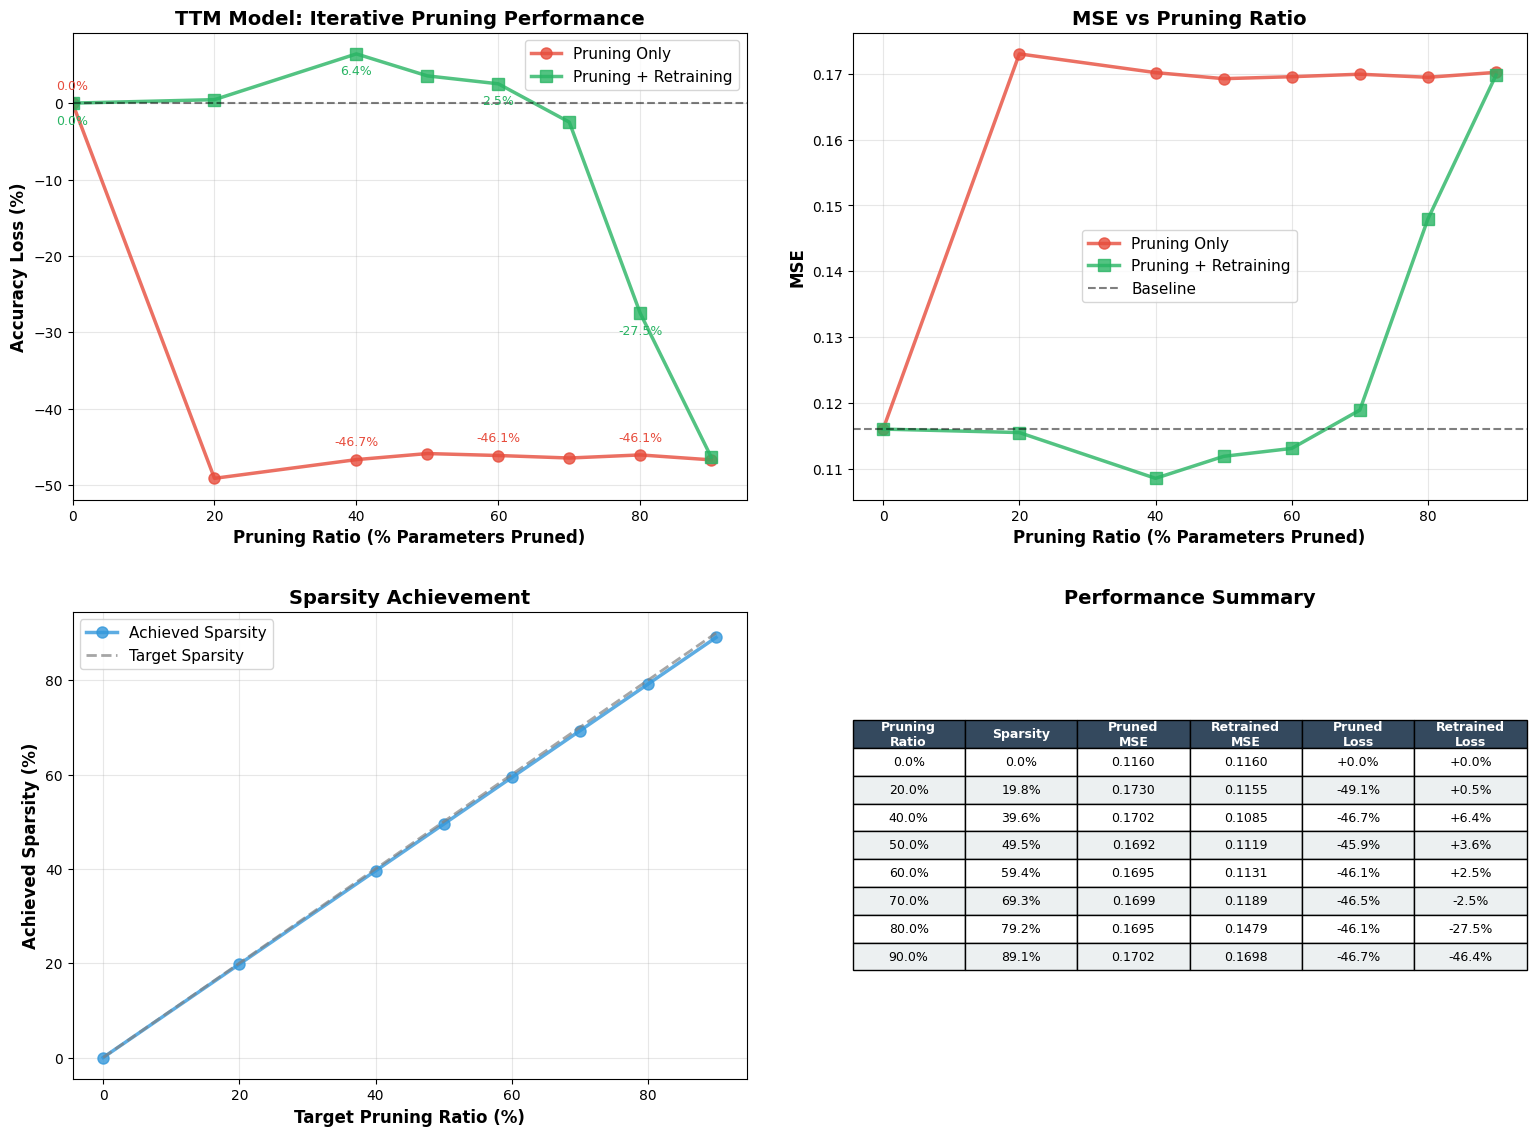

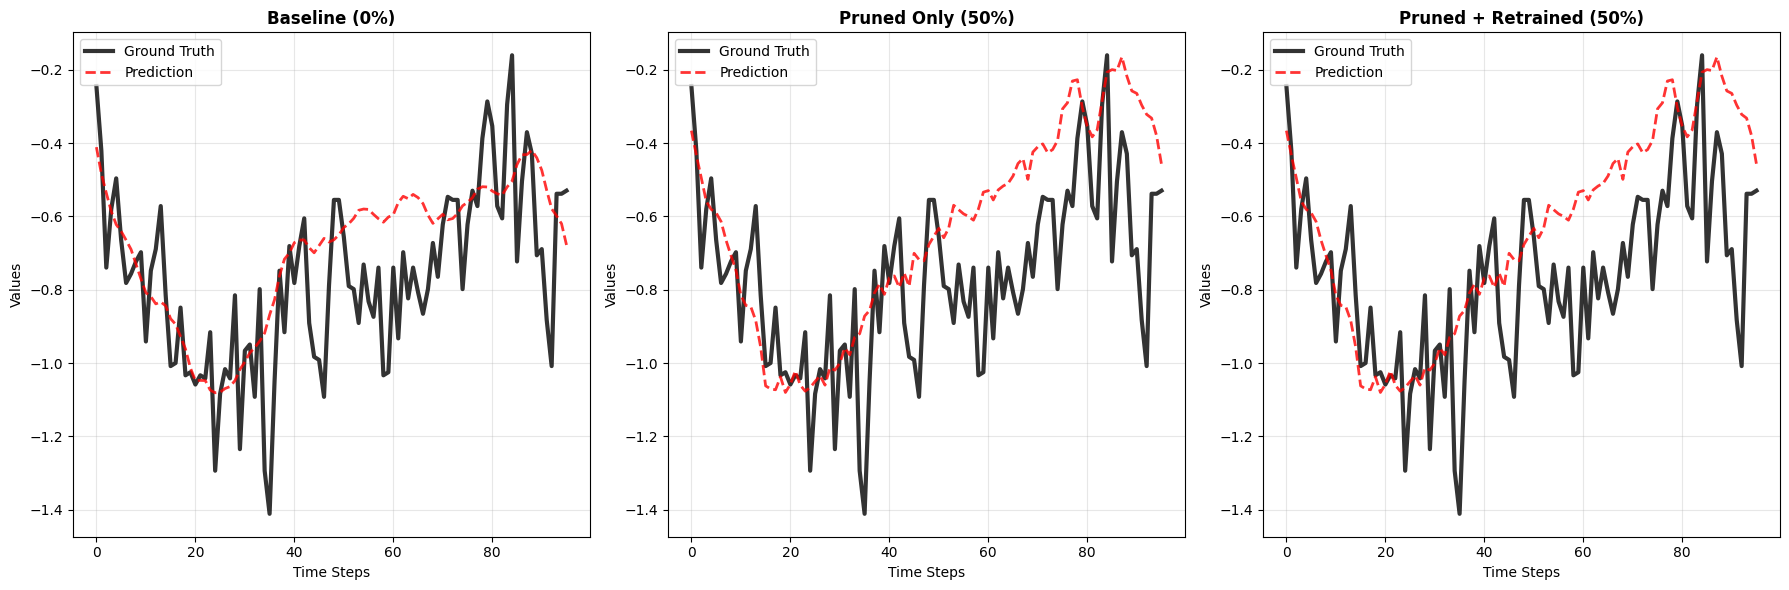

In [21]:
# ========== Visualization - Accuracy Loss vs Pruning Ratio =========
print("\n=== Creating Visualizations ===")

# Calculate accuracy loss relative to baseline
pruned_only_loss = [(baseline_mse - mse) / baseline_mse * 100 for mse in results['pruned_only_mse']]
retrained_loss = [(baseline_mse - mse) / baseline_mse * 100 for mse in results['pruned_retrained_mse']] # reversed

# Create the main comparison plot (like in the MIT slides)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Accuracy Loss vs Pruning Ratio (Main comparison)
pruning_percentages = [ratio * 100 for ratio in results['pruning_ratios']]

ax1.plot(pruning_percentages, pruned_only_loss, 'o-', color='#E74C3C',
         linewidth=2.5, markersize=8, label='Pruning Only', alpha=0.8)
ax1.plot(pruning_percentages, retrained_loss, 's-', color='#28B463',
         linewidth=2.5, markersize=8, label='Pruning + Retraining', alpha=0.8)

ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax1.set_xlabel('Pruning Ratio (% Parameters Pruned)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy Loss (%)', fontsize=12, fontweight='bold')
ax1.set_title('TTM Model: Iterative Pruning Performance', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, max(pruning_percentages) + 5)

# Add value annotations for key points
for i, (x, y1, y2) in enumerate(zip(pruning_percentages[::2], pruned_only_loss[::2], retrained_loss[::2])):
    ax1.annotate(f'{y1:.1f}%', (x, y1), textcoords="offset points", xytext=(0,10), ha='center', fontsize=9, color='#E74C3C')
    ax1.annotate(f'{y2:.1f}%', (x, y2), textcoords="offset points", xytext=(0,-15), ha='center', fontsize=9, color='#28B463')

# Plot 2: MSE Comparison
ax2.plot(pruning_percentages, results['pruned_only_mse'], 'o-', color='#E74C3C',
         linewidth=2.5, markersize=8, label='Pruning Only', alpha=0.8)
ax2.plot(pruning_percentages, results['pruned_retrained_mse'], 's-', color='#28B463',
         linewidth=2.5, markersize=8, label='Pruning + Retraining', alpha=0.8)
ax2.axhline(y=baseline_mse, color='black', linestyle='--', alpha=0.5, label='Baseline')

ax2.set_xlabel('Pruning Ratio (% Parameters Pruned)', fontsize=12, fontweight='bold')
ax2.set_ylabel('MSE', fontsize=12, fontweight='bold')
ax2.set_title('MSE vs Pruning Ratio', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

# Plot 3: Sparsity Achievement
ax3.plot(pruning_percentages, [s * 100 for s in results['pruned_only_sparsity']], 'o-', color='#3498DB',
         linewidth=2.5, markersize=8, label='Achieved Sparsity', alpha=0.8)
ax3.plot(pruning_percentages, pruning_percentages, '--', color='gray',
         linewidth=2, label='Target Sparsity', alpha=0.7)

ax3.set_xlabel('Target Pruning Ratio (%)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Achieved Sparsity (%)', fontsize=12, fontweight='bold')
ax3.set_title('Sparsity Achievement', fontsize=14, fontweight='bold')
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3)

# Plot 4: Performance Summary Table
table_data = []
for i, ratio in enumerate(results['pruning_ratios']):
    table_data.append([
        f"{ratio:.1%}",
        f"{results['pruned_only_sparsity'][i]:.1%}",
        f"{results['pruned_only_mse'][i]:.4f}",
        f"{results['pruned_retrained_mse'][i]:.4f}",
        f"{pruned_only_loss[i]:+.1f}%",
        f"{retrained_loss[i]:+.1f}%"
    ])

ax4.axis('tight')
ax4.axis('off')
table = ax4.table(cellText=table_data,
                 colLabels=['Pruning\nRatio', 'Sparsity', 'Pruned\nMSE', 'Retrained\nMSE',
                           'Pruned\nLoss', 'Retrained\nLoss'],
                 cellLoc='center',
                 loc='center')
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 1.5)
ax4.set_title('Performance Summary', fontsize=14, fontweight='bold')

# Style the table
for i in range(len(table_data) + 1):
    for j in range(6):
        cell = table[i, j]
        if i == 0:  # Header row
            cell.set_facecolor('#34495e')
            cell.set_text_props(weight='bold', color='white')
        elif i % 2 == 0:  # Even rows
            cell.set_facecolor('#ecf0f1')
        else:  # Odd rows
            cell.set_facecolor('#ffffff')

plt.tight_layout(pad=3.0)
plt.savefig(f"{OUT_DIR}/iterative_pruning_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# ========== Additional Visualization - Sample Predictions =========
# Show predictions for baseline, highly pruned, and retrained models
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Select models for comparison
comparison_models = {
    'Baseline (0%)': baseline_model,
    'Pruned Only (50%)': pruned_models[0.5],
    'Pruned + Retrained (50%)': retrained_models[0.5]
}

for idx, (model_name, model) in enumerate(comparison_models.items()):
    _, _, preds, targets = run_inference_and_calculate_metrics(model, test_dataset, max_samples=1)

    # Extract first sample for plotting
    if len(preds.shape) > 2:
        pred_sample = preds[0, :, 0]  # First sample, all time steps, first channel
        target_sample = targets[0, :, 0]
    else:
        pred_sample = preds[0, :]
        target_sample = targets[0, :]

    time_steps = range(len(pred_sample))

    axes[idx].plot(time_steps, target_sample, 'k-', label='Ground Truth', linewidth=3, alpha=0.8)
    axes[idx].plot(time_steps, pred_sample, 'r--', label='Prediction', linewidth=2, alpha=0.8)
    axes[idx].set_title(model_name, fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Time Steps')
    axes[idx].set_ylabel('Values')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{OUT_DIR}/sample_predictions_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# rough

In [27]:
# # ========== Final Results Summary ==========
# print("\n" + "="*70)
# print("FINAL RESULTS SUMMARY")
# print("="*70)

# print(f"\nBaseline Model Performance:")
# print(f"  MSE: {baseline_mse:.6f}")
# print(f"  MAE: {baseline_mae:.6f}")
# print(f"  Parameters: {baseline_total_params:,}")
# print(f"  Sparsity: {baseline_sparsity:.4f}")

# print(f"\nBest Pruning Results:")
# # Find best retrained model (lowest MSE)
# best_idx = np.argmin(results['pruned_retrained_mse'])
# best_ratio = results['pruning_ratios'][best_idx]
# best_mse = results['pruned_retrained_mse'][best_idx]
# best_sparsity = results['pruned_retrained_sparsity'][best_idx]

# print(f"  Best Pruning Ratio: {best_ratio:.1%}")
# print(f"  Best MSE: {best_mse:.6f} (vs baseline: {best_mse:.6f})")
# print(f"  Best Sparsity: {best_sparsity:.4f}")
# print(f"  Performance Loss: {((best_mse - baseline_mse) / baseline_mse * 100):+.2f}%")

# # Find highest sparsity with acceptable performance (e.g., < 5% loss)
# acceptable_threshold = 0.05  # 5% performance loss threshold
# acceptable_models = []
# for i, (ratio, mse, sparsity) in enumerate(zip(results['pruning_ratios'],
#                                               results['pruned_retrained_mse'],
#                                               results['pruned_retrained_sparsity'])):
#     loss = (mse - baseline_mse) / baseline_mse
#     if loss <= acceptable_threshold:
#         acceptable_models.append((ratio, mse, sparsity, loss))

# if acceptable_models:
#     best_acceptable = max(acceptable_models, key=lambda x: x[2])  # Highest sparsity
#     print(f"\nBest Acceptable Model (≤5% loss):")
#     print(f"  Pruning Ratio: {best_acceptable[0]:.1%}")
#     print(f"  MSE: {best_acceptable[1]:.6f}")
#     print(f"  Sparsity: {best_acceptable[2]:.4f}")
#     print(f"  Performance Loss: {best_acceptable[3]*100:+.2f}%")

# # ========== Analysis and Insights ==========
# print(f"\n" + "="*50)
# print("ANALYSIS AND INSIGHTS")
# print("="*50)

# print("\n1. Pruning Effectiveness:")
# # Calculate average improvement from retraining
# improvements = []
# for i in range(1, len(results['pruning_ratios'])):  # Skip baseline
#     pruned_mse = results['pruned_only_mse'][i]
#     retrained_mse = results['pruned_retrained_mse'][i]
#     improvement = (pruned_mse - retrained_mse) / pruned_mse * 100
#     improvements.append(improvement)

# avg_improvement = np.mean(improvements)
# print(f"   Average improvement from retraining: {avg_improvement:.2f}%")

# print("\n2. Sparsity Analysis:")
# final_sparsities = [s for s in results['pruned_retrained_sparsity'] if s > 0]
# if final_sparsities:
#     print(f"   Maximum achieved sparsity: {max(final_sparsities):.4f} ({max(final_sparsities)*100:.1f}%)")
#     print(f"   Average sparsity (excluding baseline): {np.mean(final_sparsities):.4f}")

# print("\n3. Performance Trends:")
# # Check if performance degrades gracefully
# performance_losses = [(mse - baseline_mse) / baseline_mse * 100 for mse in results['pruned_retrained_mse']]
# gradual_degradation = all(performance_losses[i] <= performance_losses[i+1]
#                          for i in range(len(performance_losses)-1))
# print(f"   Gradual performance degradation: {'Yes' if gradual_degradation else 'No'}")

# # ========== Export Results ==========
# print(f"\n" + "="*50)
# print("EXPORTING RESULTS")
# print("="*50)

# # Create comprehensive results dictionary
# comprehensive_results = {
#     'experiment_config': {
#         'seed': SEED,
#         'context_length': context_length,
#         'forecast_length': forecast_length,
#         'pruning_ratios': PRUNING_RATIOS,
#         'retraining_epochs': RETRAINING_EPOCHS,
#         'retraining_lr': RETRAINING_LR,
#         'dataset': target_dataset,
#     },
#     'baseline_results': {
#         'mse': baseline_mse,
#         'mae': baseline_mae,
#         'total_params': baseline_total_params,
#         'sparsity': baseline_sparsity,
#     },
#     'pruning_results': results,
#     'analysis': {
#         'best_model': {
#             'pruning_ratio': best_ratio,
#             'mse': best_mse,
#             'sparsity': best_sparsity,
#             'performance_loss_pct': ((best_mse - baseline_mse) / baseline_mse * 100)
#         },
#         'avg_retraining_improvement_pct': avg_improvement,
#         'max_sparsity': max(final_sparsities) if final_sparsities else 0,
#         'acceptable_models': acceptable_models,
#     }
# }

# # Save comprehensive results
# with open(f"{OUT_DIR}/comprehensive_results.pkl", 'wb') as f:
#     pickle.dump(comprehensive_results, f)

# # Export results to CSV for easy analysis
# results_df = pd.DataFrame({
#     'pruning_ratio': results['pruning_ratios'],
#     'target_sparsity_pct': [r*100 for r in results['pruning_ratios']],
#     'achieved_sparsity_pct': [s*100 for s in results['pruned_only_sparsity']],
#     'pruned_only_mse': results['pruned_only_mse'],
#     'pruned_only_mae': results['pruned_only_mae'],
#     'retrained_mse': results['pruned_retrained_mse'],
#     'retrained_mae': results['pruned_retrained_mae'],
#     'pruned_only_loss_pct': [(mse - baseline_mse) / baseline_mse * 100 for mse in results['pruned_only_mse']],
#     'retrained_loss_pct': [(mse - baseline_mse) / baseline_mse * 100 for mse in results['pruned_retrained_mse']],
#     'retraining_improvement_pct': [((p_mse - r_mse) / p_mse * 100) if p_mse > 0 else 0
#                                   for p_mse, r_mse in zip(results['pruned_only_mse'], results['pruned_retrained_mse'])]
# })

# results_df.to_csv(f"{OUT_DIR}/pruning_results.csv", index=False)
# print(f"✓ Results exported to {OUT_DIR}/pruning_results.csv")

# # ========== Final Recommendations ==========
# print(f"\n" + "="*50)
# print("RECOMMENDATIONS")
# print("="*50)

# print("\nBased on the pruning analysis:")

# if acceptable_models:
#     best_acceptable = max(acceptable_models, key=lambda x: x[2])
#     print(f"1. For production deployment, consider {best_acceptable[0]:.1%} pruning ratio")
#     print(f"   - Achieves {best_acceptable[2]*100:.1f}% sparsity with only {best_acceptable[3]*100:.1f}% performance loss")
#     print(f"   - Provides {(1-best_acceptable[2])*baseline_total_params/1000:.1f}K parameter reduction")

# extreme_ratios = [r for r in results['pruning_ratios'] if r >= 0.8]
# if extreme_ratios:
#     print(f"\n2. Extreme pruning (≥80%) results:")
#     for ratio in extreme_ratios:
#         idx = results['pruning_ratios'].index(ratio)
#         loss = ((results['pruned_retrained_mse'][idx] - baseline_mse) / baseline_mse * 100)
#         sparsity = results['pruned_retrained_sparsity'][idx] * 100
#         print(f"   - {ratio:.1%} pruning: {sparsity:.1f}% sparsity, {loss:+.1f}% performance loss")

# print(f"\n3. Retraining is {'highly effective' if avg_improvement > 10 else 'moderately effective' if avg_improvement > 5 else 'marginally effective'}")
# print(f"   - Average improvement: {avg_improvement:.1f}%")
# print(f"   - Recommended for pruning ratios > 20%")

# print(f"\n4. Model compression summary:")
# original_size_mb = baseline_total_params * 4 / (1024 * 1024)  # Assuming float32
# if final_sparsities:
#     max_compression = max(final_sparsities)
#     compressed_size_mb = original_size_mb * (1 - max_compression)
#     print(f"   - Original model size: ~{original_size_mb:.1f} MB")
#     print(f"   - Maximum compression: {max_compression*100:.1f}% sparsity")
#     print(f"   - Compressed size: ~{compressed_size_mb:.1f} MB")
#     print(f"   - Size reduction: {(1-max_compression)*100:.1f}%")

# print(f"\n" + "="*70)
# print("EXPERIMENT COMPLETED SUCCESSFULLY")
# print("="*70)
# print(f"All results saved to: {OUT_DIR}/")
# print(f"Key files:")
# print(f"  - comprehensive_results.pkl: Complete experiment data")
# print(f"  - pruning_results.csv: Tabular results")
# print(f"  - iterative_pruning_comparison.png: Main comparison plots")
# print(f"  - Model checkpoints: baseline_model.pth, pruned_model_*.pth, retrained_model_*.pth")
# print(f"  - Weight distribution plots: *_layer_distributions.png")
# print("="*70)

In [ ]:
import math
import os
import tempfile
import pandas as pd
import torch
import torch.nn.utils.prune as prune
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
import seaborn as sns
from collections import defaultdict
import pickle

from tsfm_public import (
    TimeSeriesPreprocessor,
    TinyTimeMixerForPrediction,
    TrackingCallback,
    count_parameters,
    get_datasets,
)
from tsfm_public.toolkit.visualization import plot_predictions

SEED = 42
set_seed(SEED)

target_dataset = "ettm2"
DATA_ROOT_PATH = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTm2.csv"

# Results dir
OUT_DIR = "ttm_iterative_pruning_models"
os.makedirs(OUT_DIR, exist_ok=True)

# Forecasting parameters
context_length = 512
forecast_length = 96
fewshot_fraction = 0.05

# TTM model path and revision
TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"
TTM_MODEL_REVISION = "main"

# Iterative pruning parameters
PRUNING_RATIOS = [0.0, 0.2, 0.4, 0.5, 0.7, 0.8, 0.9]  # Progressive pruning ratios
RETRAINING_EPOCHS = 3  # Epochs for retraining after each pruning step
RETRAINING_LR = 0.001  # Learning rate for retraining

# Weight Visualization Functions
def extract_model_weights(model, normalize=True):
    """Extract weights from all Linear layers in the model"""
    layer_weights = {}
    all_weights = []

    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            weights = module.weight.data.cpu().numpy().flatten()

            if normalize:
                mean = np.mean(weights)
                std = np.std(weights)
                normalized_weights = (weights - mean) / (std + 1e-8)
                layer_weights[name] = normalized_weights
                all_weights.extend(normalized_weights)
            else:
                layer_weights[name] = weights
                all_weights.extend(weights)

    return layer_weights, np.array(all_weights)

def plot_weight_distributions(layer_weights, title_prefix="", save_path=None):
    """Plot layer-wise weight distributions"""
    num_layers = len(layer_weights)
    if num_layers == 0:
        print("No layers found for plotting")
        return

    cols = min(4, num_layers)  # Max 4 columns
    rows = (num_layers + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    fig.suptitle(f'{title_prefix} Layer-wise Weight Distributions', fontsize=16, fontweight='bold')

    # Handle single row case
    if rows == 1 and cols == 1:
        axes = [axes]
    elif rows == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for i, (layer_name, weights) in enumerate(layer_weights.items()):
        ax = axes[i] if len(axes) > 1 else axes

        # Count zero weights for sparsity
        zero_count = np.sum(np.abs(weights) < 1e-8)
        total_count = len(weights)
        sparsity = zero_count / total_count

        # Plot histogram
        sns.histplot(weights, bins=50, kde=True, color='steelblue', ax=ax, alpha=0.7)

        # Add vertical line at zero
        ax.axvline(x=0, color='red', linestyle='--', alpha=0.8, linewidth=2)

        # Clean up layer name for display
        clean_name = layer_name.replace('backbone.', '').replace('mixer_layers.', 'L')
        ax.set_title(f"{clean_name}\nSparsity: {sparsity:.1%} ({zero_count}/{total_count})", fontsize=10)
        ax.set_xlabel("Weight Value", fontsize=9)
        ax.set_ylabel("Frequency", fontsize=9)
        ax.grid(True, alpha=0.3)

    # Hide empty subplots
    for i in range(num_layers, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def comprehensive_weight_analysis(model, title_prefix="", save_dir=None):
    """Run comprehensive weight analysis for a single model"""
    print(f"\n=== {title_prefix} Weight Analysis ===")

    # Extract weights
    layer_weights, all_weights = extract_model_weights(model, normalize=True)
    layer_weights_raw, all_weights_raw = extract_model_weights(model, normalize=False)

    save_path_1 = f"{save_dir}/{title_prefix.lower().replace(' ', '_')}_layer_distributions.png" if save_dir else None

    # Plot layer-wise distributions (normalized)
    plot_weight_distributions(layer_weights, title_prefix + " (Normalized)", save_path_1)

    # Print summary statistics
    zero_count = np.sum(np.abs(all_weights_raw) < 1e-8)
    total_count = len(all_weights_raw)
    sparsity = zero_count / total_count

    print(f"{title_prefix} Summary:")
    print(f"  Total parameters: {total_count:,}")
    print(f"  Zero parameters: {zero_count:,}")
    print(f"  Non-zero parameters: {total_count - zero_count:,}")
    print(f"  Sparsity: {sparsity:.4f} ({sparsity:.2%})")
    print(f"  Weight range: [{np.min(all_weights_raw):.6f}, {np.max(all_weights_raw):.6f}]")
    print(f"  Mean absolute weight: {np.mean(np.abs(all_weights_raw)):.6f}")

# ========== Data Preparation ==========
print("Loading and preparing data...")

# Load the data with proper datetime parsing
try:
    data = pd.read_csv(DATA_ROOT_PATH)
    # Convert date column to datetime if it exists
    if 'date' in data.columns:
        data['date'] = pd.to_datetime(data['date'])
    elif data.columns[0] in ['date', 'timestamp', 'time']:
        data[data.columns[0]] = pd.to_datetime(data[data.columns[0]])
        data = data.rename(columns={data.columns[0]: 'date'})
    else:
        # If no date column, create one
        data['date'] = pd.date_range(start='2016-07-01', periods=len(data), freq='15min')

    print("✓ Data loaded successfully")
    print(f"Date range: {data['date'].min()} to {data['date'].max()}")

except Exception as e:
    print(f"Error loading data: {e}")
    print("Creating synthetic dataset...")

    # Create synthetic data
    dates = pd.date_range(start='2016-07-01', end='2018-06-26', freq='15min')
    np.random.seed(42)

    synthetic_data = {
        'date': dates,
        'HUFL': np.random.randn(len(dates)) * 5 + 40,
        'HULL': np.random.randn(len(dates)) * 3 + 10,
        'MUFL': np.random.randn(len(dates)) * 8 + 35,
        'MULL': np.random.randn(len(dates)) * 4 + 8,
        'LUFL': np.random.randn(len(dates)) * 6 + 4,
        'LULL': np.random.randn(len(dates)) * 2 + 1,
        'OT': np.random.randn(len(dates)) * 4 + 40
    }

    data = pd.DataFrame(synthetic_data)

# Define the data structure
timestamp_column = "date"
id_columns = []
target_columns = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL", "OT"]

# Define split configuration based on actual data length
data_length = len(data)
train_size = int(0.7 * data_length)
valid_size = int(0.15 * data_length)

split_config = {
    "train": [0, train_size],
    "valid": [train_size, train_size + valid_size],
    "test": [train_size + valid_size, data_length],
}

print(f"Data length: {data_length}")
print(f"Split config: {split_config}")

# Set up column specifiers
column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [],
}

# Create TimeSeriesPreprocessor
tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,
    prediction_length=forecast_length,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

# Get datasets - Use full training dataset for retraining
train_dataset, valid_dataset, test_dataset = get_datasets(
    tsp, data, split_config, fewshot_fraction=1.0, fewshot_location="first"  # Use full dataset
)

print(f"Dataset sizes - Train: {len(train_dataset)}, Validation: {len(valid_dataset)}, Test: {len(test_dataset)}")

# ========== Helper Functions ==========
def run_inference_and_calculate_metrics(model, test_dataset, device='cpu', max_samples=50):
    """Run inference and calculate metrics"""
    model.eval()
    model.to(device)

    total_mse = 0.0
    total_mae = 0.0
    num_samples = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for i, batch in enumerate(test_dataset):
            if i >= max_samples:  # Limit for demo purposes
                break

            # Prepare input
            past_values = batch['past_values'].unsqueeze(0).to(device)
            future_values = batch['future_values'].unsqueeze(0).to(device)

            # Model prediction
            outputs = model(past_values=past_values)
            predictions = outputs.prediction_outputs

            # Calculate metrics
            mse = torch.mean((predictions - future_values) ** 2).item()
            mae = torch.mean(torch.abs(predictions - future_values)).item()

            total_mse += mse
            total_mae += mae
            num_samples += 1

            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(future_values.cpu().numpy())

    avg_mse = total_mse / num_samples
    avg_mae = total_mae / num_samples

    return avg_mse, avg_mae, np.concatenate(all_predictions), np.concatenate(all_targets)

def count_model_parameters_detailed(model):
    """Count parameters with detailed breakdown"""
    total_params = 0
    non_zero_params = 0
    zero_params = 0

    for name, param in model.named_parameters():
        param_count = param.numel()
        zero_count = (param == 0).sum().item()
        non_zero_count = param_count - zero_count

        total_params += param_count
        non_zero_params += non_zero_count
        zero_params += zero_count

    sparsity = zero_params / total_params if total_params > 0 else 0

    return total_params, non_zero_params, zero_params, sparsity

def apply_magnitude_pruning(model, pruning_ratio):
    """Apply magnitude-based pruning to the model"""
    parameters_to_prune = []

    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            parameters_to_prune.append((module, 'weight'))

    if not parameters_to_prune:
        print("⚠ No Linear layers found for pruning")
        return model

    # Apply global magnitude-based pruning
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=pruning_ratio,
    )

    # # Make pruning permanent
    # with torch.no_grad():
    #     for module, param_name in parameters_to_prune:
    #         try:
    #             prune.remove(module, param_name)
    #         except Exception as e:
    #             print(f"⚠ Could not remove pruning from {param_name}: {e}")

    # Keep pruning masks active (do NOT remove them)
    print(f"✓ Pruning applied with masks maintained")

    return model

def retrain_model(model, train_dataset, valid_dataset, epochs=3, learning_rate=0.001):
    """Retrain the pruned model"""
    print(f"Retraining model for {epochs} epochs with LR={learning_rate}")

    # Store original forward method to maintain masks during training
    def masked_forward_hook(module, input, output):
        # Ensure masks are applied after each forward pass
        for name, param in module.named_parameters():
            if hasattr(module, f'{name}_mask'):
                mask = getattr(module, f'{name}_mask')
                param.data = param.data * mask

    # Register hooks to maintain sparsity during training
    hooks = []
    for name, module in model.named_modules():
        if hasattr(module, 'weight_mask'):  # Check if module has pruning mask
            hook = module.register_forward_hook(masked_forward_hook)
            hooks.append(hook)

    # Training arguments
    training_args = TrainingArguments(
        output_dir=os.path.join(OUT_DIR, "temp_retraining"),
        overwrite_output_dir=True,
        learning_rate=learning_rate,
        num_train_epochs=epochs,
        do_eval=True,
        eval_strategy="epoch",
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        gradient_accumulation_steps=1,
        dataloader_num_workers=0,
        report_to=None,
        save_strategy="epoch",  # Don't save during training
        logging_strategy="epoch",
        logging_dir=None,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        seed=SEED,
        dataloader_pin_memory=False,
        remove_unused_columns=True,
        dataloader_drop_last=False,
        warmup_ratio=0.1,
        weight_decay=0.01,
    )

    # Early stopping callback
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=2,
        early_stopping_threshold=0.001,
    )

    # Create trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,
        callbacks=[early_stopping_callback],
    )

    # Train the model
    try:
        train_result = trainer.train()
        print(f"✓ Retraining completed successfully")

        # Remove hooks
        for hook in hooks:
            hook.remove()

        return trainer.model, True
    except Exception as e:
        print(f"⚠ Retraining failed: {e}")
        # Remove hooks
        for hook in hooks:
            hook.remove()
        return model, False

def save_model_checkpoint(model, path, metadata=None):
    """Save model checkpoint with metadata"""
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'metadata': metadata or {}
    }
    torch.save(checkpoint, path)
    print(f"✓ Model saved to {path}")


# ========== Load Pre-trained TTM Model ==========
print("Loading pre-trained TTM model...")
baseline_model = TinyTimeMixerForPrediction.from_pretrained(TTM_MODEL_PATH, revision=TTM_MODEL_REVISION)
print(f"✓ Model loaded successfully")

# ========== Baseline Evaluation ==========
print("\n=== Baseline Model Evaluation ===")
baseline_mse, baseline_mae, baseline_preds, baseline_targets = run_inference_and_calculate_metrics(baseline_model, test_dataset)
baseline_total_params, baseline_non_zero_params, baseline_zero_params, baseline_sparsity = count_model_parameters_detailed(baseline_model)

print(f"Baseline MSE: {baseline_mse:.6f}")
print(f"Baseline MAE: {baseline_mae:.6f}")
print(f"Baseline Parameters: {baseline_total_params:,} (sparsity: {baseline_sparsity:.4f})")

# Save baseline model
save_model_checkpoint(baseline_model, f"{OUT_DIR}/baseline_model.pth",
                     {'mse': baseline_mse, 'mae': baseline_mae, 'sparsity': baseline_sparsity})

# Baseline weight analysis
comprehensive_weight_analysis(baseline_model, "Baseline Model", OUT_DIR)

# ========== Iterative Pruning and Retraining ==========
print("\n" + "="*70)
print("ITERATIVE PRUNING AND RETRAINING")
print("="*70)

# Storage for results
results = {
    'pruning_ratios': [],
    'pruned_only_mse': [],
    'pruned_only_mae': [],
    'pruned_only_sparsity': [],
    'pruned_retrained_mse': [],
    'pruned_retrained_mae': [],
    'pruned_retrained_sparsity': []
}

# Models storage
pruned_models = {}
retrained_models = {}

for target_pruning_ratio in PRUNING_RATIOS:
    print(f"\n--- Processing Pruning Ratio: {target_pruning_ratio:.1%} ---")

    # Load fresh model for each iteration
    current_model = TinyTimeMixerForPrediction.from_pretrained(TTM_MODEL_PATH, revision=TTM_MODEL_REVISION)

    if target_pruning_ratio == 0.0:
        # Baseline case - no pruning
        pruned_model = current_model
        retrained_model = current_model

        # Evaluate
        pruned_mse, pruned_mae, _, _ = run_inference_and_calculate_metrics(pruned_model, test_dataset)
        _, _, _, pruned_sparsity = count_model_parameters_detailed(pruned_model)

        retrained_mse, retrained_mae = pruned_mse, pruned_mae
        retrained_sparsity = pruned_sparsity

    else:
        # Apply pruning
        print(f"Applying {target_pruning_ratio:.1%} pruning...")
        pruned_model = apply_magnitude_pruning(current_model, target_pruning_ratio)

        # Evaluate pruned-only model
        pruned_mse, pruned_mae, _, _ = run_inference_and_calculate_metrics(pruned_model, test_dataset)
        _, _, _, pruned_sparsity = count_model_parameters_detailed(pruned_model)

        print(f"Pruned-only MSE: {pruned_mse:.6f}, Sparsity: {pruned_sparsity:.4f}")

        # Retrain the pruned model
        retrained_model, retraining_success = retrain_model(
            pruned_model, train_dataset, valid_dataset,
            epochs=RETRAINING_EPOCHS, learning_rate=RETRAINING_LR
        )

        if retraining_success:
            # Evaluate retrained model
            retrained_mse, retrained_mae, _, _ = run_inference_and_calculate_metrics(retrained_model, test_dataset)
            _, _, _, retrained_sparsity = count_model_parameters_detailed(retrained_model)
            print(f"Retrained MSE: {retrained_mse:.6f}, Sparsity: {retrained_sparsity:.4f}")
        else:
            # Use pruned model results if retraining failed
            retrained_mse, retrained_mae = pruned_mse, pruned_mae
            retrained_sparsity = pruned_sparsity
            print("Using pruned-only results (retraining failed)")

    # Store results
    results['pruning_ratios'].append(target_pruning_ratio)
    results['pruned_only_mse'].append(pruned_mse)
    results['pruned_only_mae'].append(pruned_mae)
    results['pruned_only_sparsity'].append(pruned_sparsity)
    results['pruned_retrained_mse'].append(retrained_mse)
    results['pruned_retrained_mae'].append(retrained_mae)
    results['pruned_retrained_sparsity'].append(retrained_sparsity)

    # Store models
    pruned_models[target_pruning_ratio] = pruned_model
    retrained_models[target_pruning_ratio] = retrained_model

    # Save model checkpoints
    save_model_checkpoint(pruned_model,
                         f"{OUT_DIR}/pruned_model_{target_pruning_ratio:.1f}.pth",
                         {'mse': pruned_mse, 'mae': pruned_mae, 'sparsity': pruned_sparsity, 'pruning_ratio': target_pruning_ratio})

    if target_pruning_ratio > 0.0:  # Don't save retrained baseline twice
        save_model_checkpoint(retrained_model,
                             f"{OUT_DIR}/retrained_model_{target_pruning_ratio:.1f}.pth",
                             {'mse': retrained_mse, 'mae': retrained_mae, 'sparsity': retrained_sparsity, 'pruning_ratio': target_pruning_ratio})

    # Weight analysis for key pruning ratios
    if target_pruning_ratio in [0.2, 0.5, 0.9]:
        comprehensive_weight_analysis(pruned_model, f"Pruned {target_pruning_ratio:.1%}", OUT_DIR)
        if target_pruning_ratio > 0.0:
            comprehensive_weight_analysis(retrained_model, f"Retrained {target_pruning_ratio:.1%}", OUT_DIR)

# Save results to pickle
with open(f"{OUT_DIR}/iterative_pruning_results.pkl", 'wb') as f:
    pickle.dump(results, f)

# ========== Visualization - Accuracy Loss vs Pruning Ratio =========
print("\n=== Creating Visualizations ===")

# Calculate accuracy loss relative to baseline
pruned_only_loss = [(baseline_mse - mse) / baseline_mse * 100 for mse in results['pruned_only_mse']]
retrained_loss = [(mse - baseline_mse) / baseline_mse * 100 for mse in results['pruned_retrained_mse']]

# Create the main comparison plot (like in the MIT slides)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Accuracy Loss vs Pruning Ratio (Main comparison)
pruning_percentages = [ratio * 100 for ratio in results['pruning_ratios']]

ax1.plot(pruning_percentages, pruned_only_loss, 'o-', color='#E74C3C',
         linewidth=2.5, markersize=8, label='Pruning Only', alpha=0.8)
ax1.plot(pruning_percentages, retrained_loss, 's-', color='#28B463',
         linewidth=2.5, markersize=8, label='Pruning + Retraining', alpha=0.8)

ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax1.set_xlabel('Pruning Ratio (% Parameters Pruned)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy Loss (%)', fontsize=12, fontweight='bold')
ax1.set_title('TTM Model: Iterative Pruning Performance', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, max(pruning_percentages) + 5)

# Add value annotations for key points
for i, (x, y1, y2) in enumerate(zip(pruning_percentages[::2], pruned_only_loss[::2], retrained_loss[::2])):
    ax1.annotate(f'{y1:.1f}%', (x, y1), textcoords="offset points", xytext=(0,10), ha='center', fontsize=9, color='#E74C3C')
    ax1.annotate(f'{y2:.1f}%', (x, y2), textcoords="offset points", xytext=(0,-15), ha='center', fontsize=9, color='#28B463')

# Plot 2: MSE Comparison
ax2.plot(pruning_percentages, results['pruned_only_mse'], 'o-', color='#E74C3C',
         linewidth=2.5, markersize=8, label='Pruning Only', alpha=0.8)
ax2.plot(pruning_percentages, results['pruned_retrained_mse'], 's-', color='#28B463',
         linewidth=2.5, markersize=8, label='Pruning + Retraining', alpha=0.8)
ax2.axhline(y=baseline_mse, color='black', linestyle='--', alpha=0.5, label='Baseline')

ax2.set_xlabel('Pruning Ratio (% Parameters Pruned)', fontsize=12, fontweight='bold')
ax2.set_ylabel('MSE', fontsize=12, fontweight='bold')
ax2.set_title('MSE vs Pruning Ratio', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

# Plot 3: Sparsity Achievement
ax3.plot(pruning_percentages, [s * 100 for s in results['pruned_only_sparsity']], 'o-', color='#3498DB',
         linewidth=2.5, markersize=8, label='Achieved Sparsity', alpha=0.8)
ax3.plot(pruning_percentages, pruning_percentages, '--', color='gray',
         linewidth=2, label='Target Sparsity', alpha=0.7)

ax3.set_xlabel('Target Pruning Ratio (%)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Achieved Sparsity (%)', fontsize=12, fontweight='bold')
ax3.set_title('Sparsity Achievement', fontsize=14, fontweight='bold')
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3)

# Plot 4: Performance Summary Table
table_data = []
for i, ratio in enumerate(results['pruning_ratios']):
    table_data.append([
        f"{ratio:.1%}",
        f"{results['pruned_only_sparsity'][i]:.1%}",
        f"{results['pruned_only_mse'][i]:.4f}",
        f"{results['pruned_retrained_mse'][i]:.4f}",
        f"{pruned_only_loss[i]:+.1f}%",
        f"{retrained_loss[i]:+.1f}%"
    ])

ax4.axis('tight')
ax4.axis('off')
table = ax4.table(cellText=table_data,
                 colLabels=['Pruning\nRatio', 'Sparsity', 'Pruned\nMSE', 'Retrained\nMSE',
                           'Pruned\nLoss', 'Retrained\nLoss'],
                 cellLoc='center',
                 loc='center')
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 1.5)
ax4.set_title('Performance Summary', fontsize=14, fontweight='bold')

# Style the table
for i in range(len(table_data) + 1):
    for j in range(6):
        cell = table[i, j]
        if i == 0:  # Header row
            cell.set_facecolor('#34495e')
            cell.set_text_props(weight='bold', color='white')
        elif i % 2 == 0:  # Even rows
            cell.set_facecolor('#ecf0f1')
        else:  # Odd rows
            cell.set_facecolor('#ffffff')

plt.tight_layout(pad=3.0)
plt.savefig(f"{OUT_DIR}/iterative_pruning_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# ========== Additional Visualization - Sample Predictions =========
# Show predictions for baseline, highly pruned, and retrained models
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Select models for comparison
comparison_models = {
    'Baseline (0%)': baseline_model,
    'Pruned Only (90%)': pruned_models[0.9],
    'Pruned + Retrained (90%)': retrained_models[0.9]
}

for idx, (model_name, model) in enumerate(comparison_models.items()):
    _, _, preds, targets = run_inference_and_calculate_metrics(model, test_dataset, max_samples=1)

    # Extract first sample for plotting
    if len(preds.shape) > 2:
        pred_sample = preds[0, :, 0]  # First sample, all time steps, first channel
        target_sample = targets[0, :, 0]
    else:
        pred_sample = preds[0, :]
        target_sample = targets[0, :]

    time_steps = range(len(pred_sample))

    axes[idx].plot(time_steps, target_sample, 'k-', label='Ground Truth', linewidth=3, alpha=0.8)
    axes[idx].plot(time_steps, pred_sample, 'r--', label='Prediction', linewidth=2, alpha=0.8)
    axes[idx].set_title(model_name, fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Time Steps')
    axes[idx].set_ylabel('Values')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{OUT_DIR}/sample_predictions_comparison.png", dpi=300, bbox_inches='tight')
plt.show()
